<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Trabajo de Fin de Máster</header1></center>
<left><h1>Predicción de gastos operativos mediante técnicas de aprendizaje automático: Análisis del área contable del sistema SPRO de una empresa de Manta, Ecuador</header1></left>

*   Espinoza Zambrano José Vicente

In [511]:
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('../dataset_v2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   anio_id                       6068 non-null   int64  
 1   mes_id                        6068 non-null   int64  
 2   proyecto_id                   6068 non-null   int64  
 3   salario_basico                6068 non-null   int64  
 4   canasta_basica_familiar       6068 non-null   float64
 5   iva                           6068 non-null   int64  
 6   valor_activos_fijos           6068 non-null   float64
 7   numero_activos_fijos          6068 non-null   int64  
 8   empleados_menor_basico        6068 non-null   int64  
 9   empleados_basico_mil          6068 non-null   int64  
 10  empleados_mil_dos_mil         6068 non-null   int64  
 11  empleados_dos_mil_cuatro_mil  6068 non-null   int64  
 12  jubilados_menor_basico        6068 non-null   int64  
 13  ing

In [5]:
df.shape

(6068, 18)

In [8]:
df.head()

anio_id  mes_id  proyecto_id  salario_basico  canasta_basica_familiar  iva  \
0     2023       4            2             450                   764.71   12   
1     2023       4            2             450                   764.71   12   
2     2023       4            2             450                   764.71   12   
3     2023       4            2             450                   764.71   12   
4     2023       4            2             450                   764.71   12   

   valor_activos_fijos  numero_activos_fijos  empleados_menor_basico  \
0           2643880.47                   135                       1   
1           2643880.47                   135                       1   
2           2643880.47                   135                       1   
3           2643880.47                   135                       1   
4           2643880.47                   135                       1   

   empleados_basico_mil  empleados_mil_dos_mil  empleados_dos_mil_cuatro_mil  \
0                    97                      6                             2   
1                    97                      6                             2   
2                    97                      6                             2   
3                    97                      6                             2   
4                    97                      6                             2   

   jubilados_menor_basico  ingreso_operacional  ingreso_no_operacional  \
0                      25           1229886.24                 5219.82   
1                      25           1229886.24                 5219.82   
2                      25           1229886.24                 5219.82   
3                      25           1229886.24                 5219.82   
4                      25           1229886.24                 5219.82   

  gasto_operativo            gasto_operativo_nombre  gasto_operativo_valor  
0    5.1.01.16.05                 TELEFONIA CELULAR                 267.11  
1    5.1.01.18.01                          SOFTWARE                1041.69  
2    5.1.01.19.01            GUARDIANIA Y SEGURIDAD               19070.80  
3    5.1.01.20.03  OTROS IMPUESTOS Y CONTRIBUCIONES                 355.53  
4    5.1.01.26.01           Depreciación de Equipos                5059.06

In [10]:
df[df['gasto_operativo_valor'] <= 0]

Empty DataFrame
Columns: [anio_id, mes_id, proyecto_id, salario_basico, canasta_basica_familiar, iva, valor_activos_fijos, numero_activos_fijos, empleados_menor_basico, empleados_basico_mil, empleados_mil_dos_mil, empleados_dos_mil_cuatro_mil, jubilados_menor_basico, ingreso_operacional, ingreso_no_operacional, gasto_operativo, gasto_operativo_nombre, gasto_operativo_valor]
Index: []

In [12]:
df = df.drop(["proyecto_id"], axis=1)

In [14]:
df['gasto_operativo'] = df['gasto_operativo'].astype('category')
df['gasto_operativo_nombre'] = df['gasto_operativo_nombre'].astype('category')
df.describe()

anio_id       mes_id  salario_basico  canasta_basica_familiar  \
count  6068.000000  6068.000000     6068.000000              6068.000000   
mean   2023.842947     6.405735      458.429466               793.558934   
std       0.696755     3.382711        6.967546                 9.523401   
min    2023.000000     1.000000      450.000000               764.710000   
25%    2023.000000     4.000000      450.000000               795.750000   
50%    2024.000000     6.000000      460.000000               797.970000   
75%    2024.000000     9.000000      460.000000               797.970000   
max    2025.000000    12.000000      470.000000               798.310000   

               iva  valor_activos_fijos  numero_activos_fijos  \
count  6068.000000         6.068000e+03           6068.000000   
mean     13.684904         9.688599e+05             86.957811   
std       1.488682         7.471638e+05             33.596701   
min      12.000000         8.446300e+02              1.000000   
25%      12.000000         5.766376e+05             72.000000   
50%      15.000000         7.143658e+05             87.000000   
75%      15.000000         9.852933e+05            109.000000   
max      15.000000         2.643880e+06            145.000000   

       empleados_menor_basico  empleados_basico_mil  empleados_mil_dos_mil  \
count             6068.000000           6068.000000            6068.000000   
mean                 0.757251             60.106955               1.661503   
std                  1.371099             26.259886               1.397726   
min                  0.000000              1.000000               0.000000   
25%                  0.000000             53.000000               1.000000   
50%                  0.000000             59.000000               1.000000   
75%                  1.000000             63.000000               2.000000   
max                 11.000000            112.000000               6.000000   

       empleados_dos_mil_cuatro_mil  jubilados_menor_basico  \
count                   6068.000000             6068.000000   
mean                       1.211107               11.702538   
std                        0.794178                8.604146   
min                        0.000000                0.000000   
25%                        1.000000                4.000000   
50%                        1.000000                9.000000   
75%                        2.000000               15.000000   
max                        2.000000               29.000000   

       ingreso_operacional  ingreso_no_operacional  gasto_operativo_valor  
count         6.068000e+03             6068.000000            6068.000000  
mean          6.258522e+05             1808.660028            2541.530033  
std           3.793073e+05             1899.164740            9018.285381  
min           5.619125e+04              331.770000               0.010000  
25%           3.327938e+05              523.530000             115.075000  
50%           5.502722e+05              725.080000             389.980000  
75%           8.283641e+05             2682.690000            1438.712500  
max           1.294990e+06             6973.220000          224111.530000

In [16]:
valores_atipicos = df['gasto_operativo_valor'].quantile(0.75) + 1.5 * (1438.6425- df['gasto_operativo_valor'].quantile(0.25)) #1.5 a de distancia son atipicos
valores_extremos = df['gasto_operativo_valor'].quantile(0.75) + 3 * (1438.6425- df['gasto_operativo_valor'].quantile(0.25)) #son extremos

print(f"Atípico (> Q3 + 1.5 * (Q3 - Q1)): {valores_atipicos}")
print(f"Extremo (> Q3 + 3 * (Q3 - Q1)): {valores_extremos}")

Atípico (> Q3 + 1.5 * (Q3 - Q1)): 3424.06375
Extremo (> Q3 + 3 * (Q3 - Q1)): 5409.414999999999


In [18]:
# Total de registros
total = len(df)

# Valores atípicos
atipicos = len(df[df['gasto_operativo_valor'] > valores_atipicos])

# Valores extremos
extremos = len(df[df['gasto_operativo_valor'] > valores_extremos])

print(f"Número de registros: {total}")
print(f"Número de valores atípicos: {atipicos}")
print(f"Número de valores extremos: {extremos}")

Número de registros: 6068
Número de valores atípicos: 755
Número de valores extremos: 406


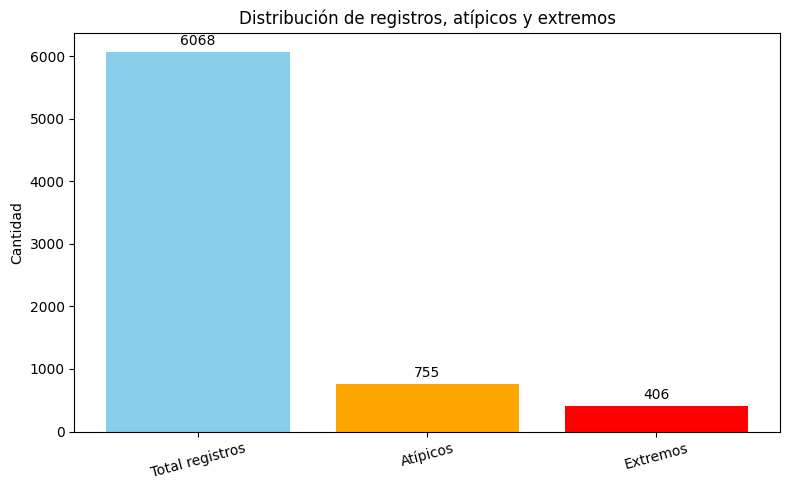

In [20]:
# Preparar datos para graficar
valores = [total, atipicos, extremos]
categorias = ['Total registros', 'Atípicos', 'Extremos']

# Crear gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(categorias, valores, color=['skyblue', 'orange', 'red'])
plt.title('Distribución de registros, atípicos y extremos')
plt.ylabel('Cantidad')
plt.xticks(rotation=15)

# Etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + total*0.01, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   anio_id                       6068 non-null   int64   
 1   mes_id                        6068 non-null   int64   
 2   salario_basico                6068 non-null   int64   
 3   canasta_basica_familiar       6068 non-null   float64 
 4   iva                           6068 non-null   int64   
 5   valor_activos_fijos           6068 non-null   float64 
 6   numero_activos_fijos          6068 non-null   int64   
 7   empleados_menor_basico        6068 non-null   int64   
 8   empleados_basico_mil          6068 non-null   int64   
 9   empleados_mil_dos_mil         6068 non-null   int64   
 10  empleados_dos_mil_cuatro_mil  6068 non-null   int64   
 11  jubilados_menor_basico        6068 non-null   int64   
 12  ingreso_operacional           6068 non-null   fl

In [24]:
df.isnull().any()

anio_id                         False
mes_id                          False
salario_basico                  False
canasta_basica_familiar         False
iva                             False
valor_activos_fijos             False
numero_activos_fijos            False
empleados_menor_basico          False
empleados_basico_mil            False
empleados_mil_dos_mil           False
empleados_dos_mil_cuatro_mil    False
jubilados_menor_basico          False
ingreso_operacional             False
ingreso_no_operacional          False
gasto_operativo                 False
gasto_operativo_nombre          False
gasto_operativo_valor           False
dtype: bool

In [26]:
df.duplicated().sum()

np.int64(0)

Text(0, 0.5, 'Cantidad')

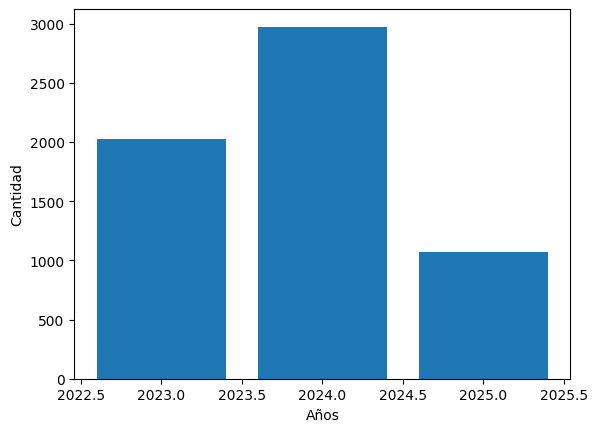

In [28]:
conteo = df['anio_id'].value_counts()

plt.bar(conteo.index, conteo)
plt.xlabel('Años')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad')

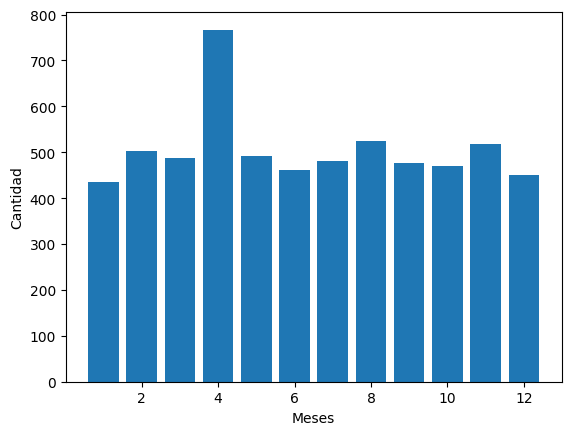

In [30]:
conteo = df['mes_id'].value_counts()

plt.bar(conteo.index, conteo)
plt.xlabel('Meses')
plt.ylabel('Cantidad')

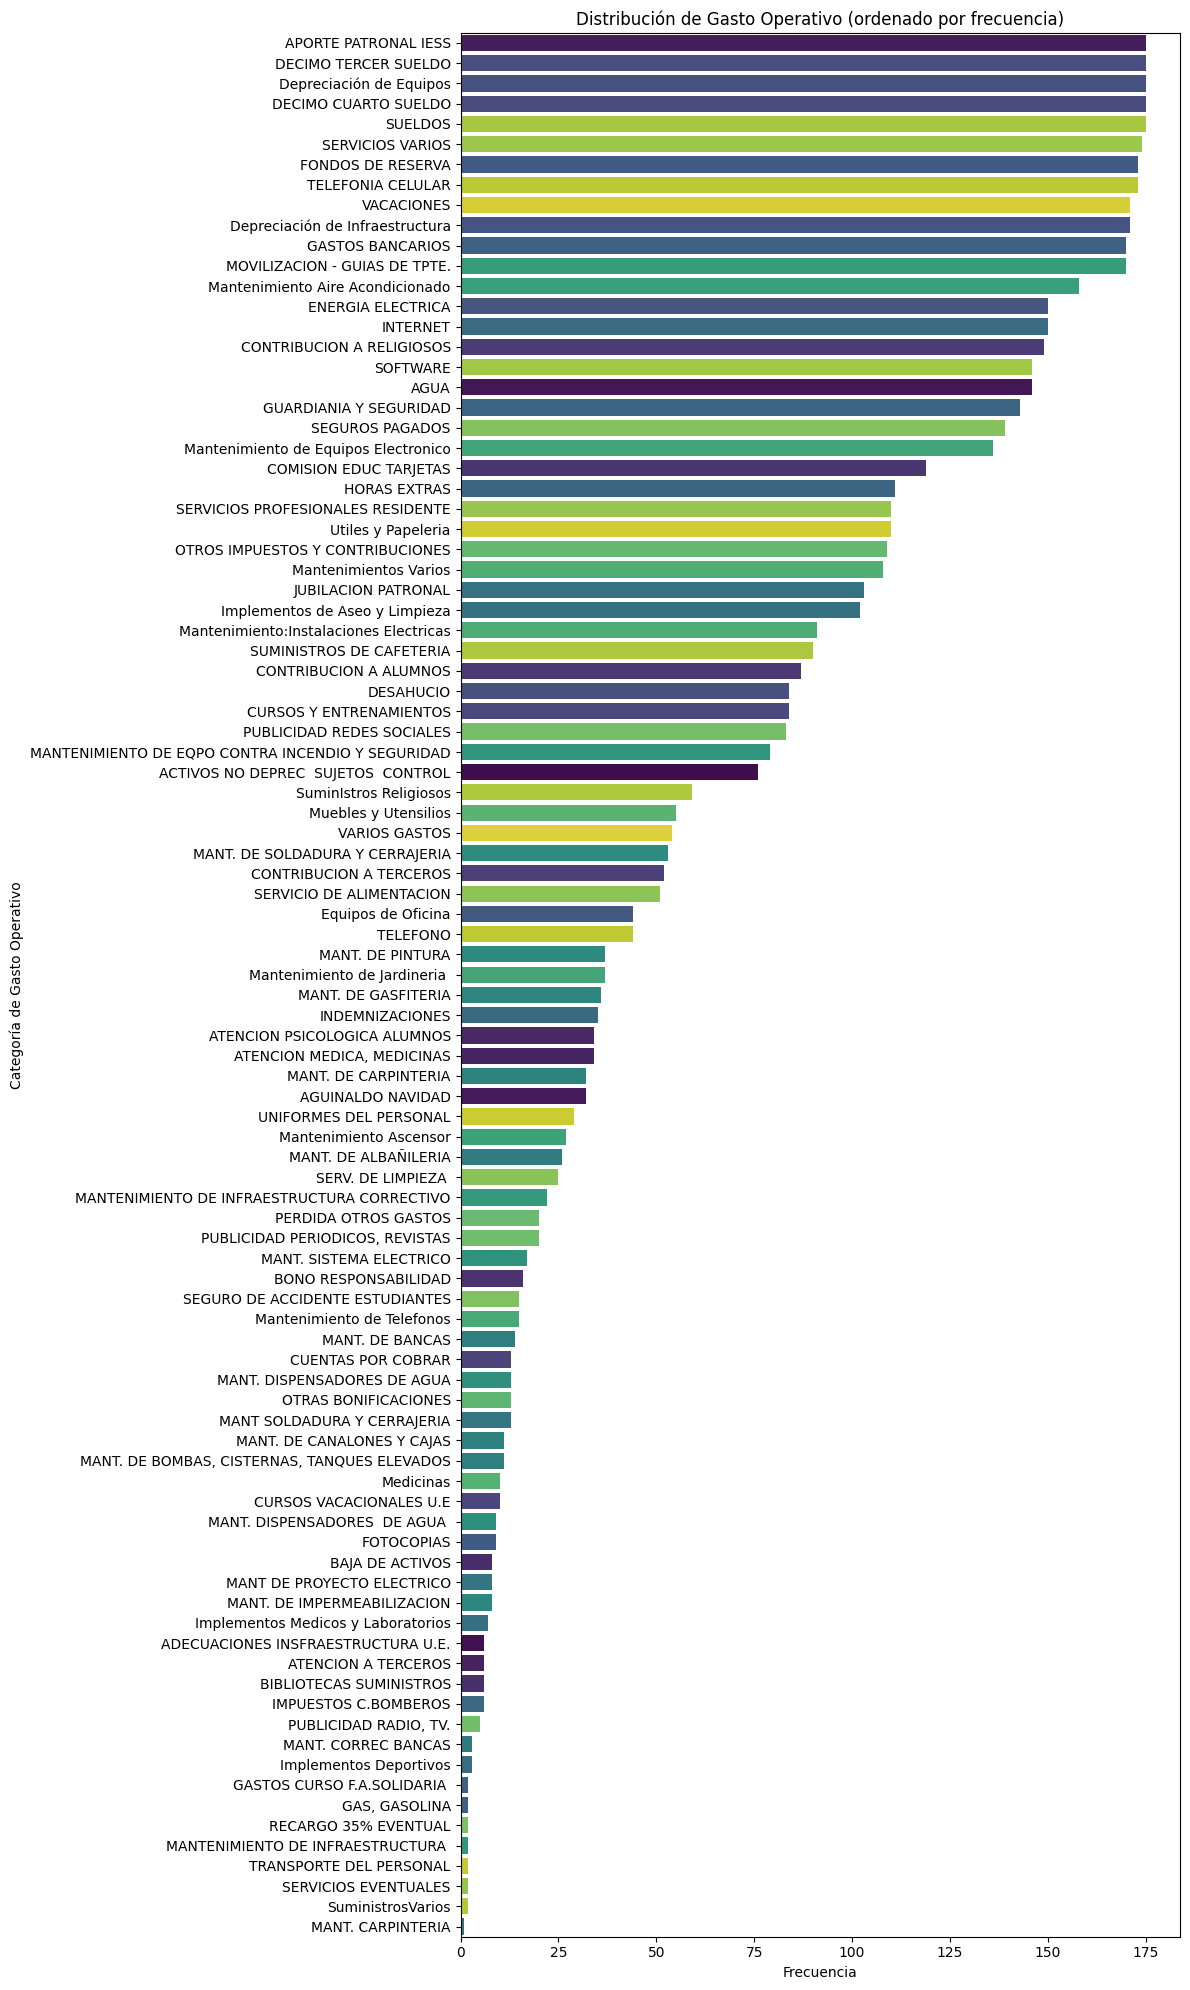

In [32]:

# Obtener frecuencias
gasto_counts = df['gasto_operativo_nombre'].value_counts()

# Reordenar categorías del tipo 'category' (si lo es)
df['gasto_operativo_nombre'] = pd.Categorical(
    df['gasto_operativo_nombre'],
    categories=gasto_counts.index,  # Orden por frecuencia
    ordered=True
)

# Graficar
plt.figure(figsize=(12, 20))
sns.countplot(
    data=df,
    y='gasto_operativo_nombre',
    order=gasto_counts.index,
    hue='gasto_operativo_nombre',  # Agrega hue para usar la paleta
    palette='viridis',
    legend=False  # No mostrar leyenda porque hue y y son iguales
)

plt.title('Distribución de Gasto Operativo (ordenado por frecuencia)')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría de Gasto Operativo')
plt.tight_layout()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13096\2826626127.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gasto_suma = df.groupby('gasto_operativo_nombre')['gasto_operativo_valor'].sum().sort_values(ascending=False)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13096\2826626127.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


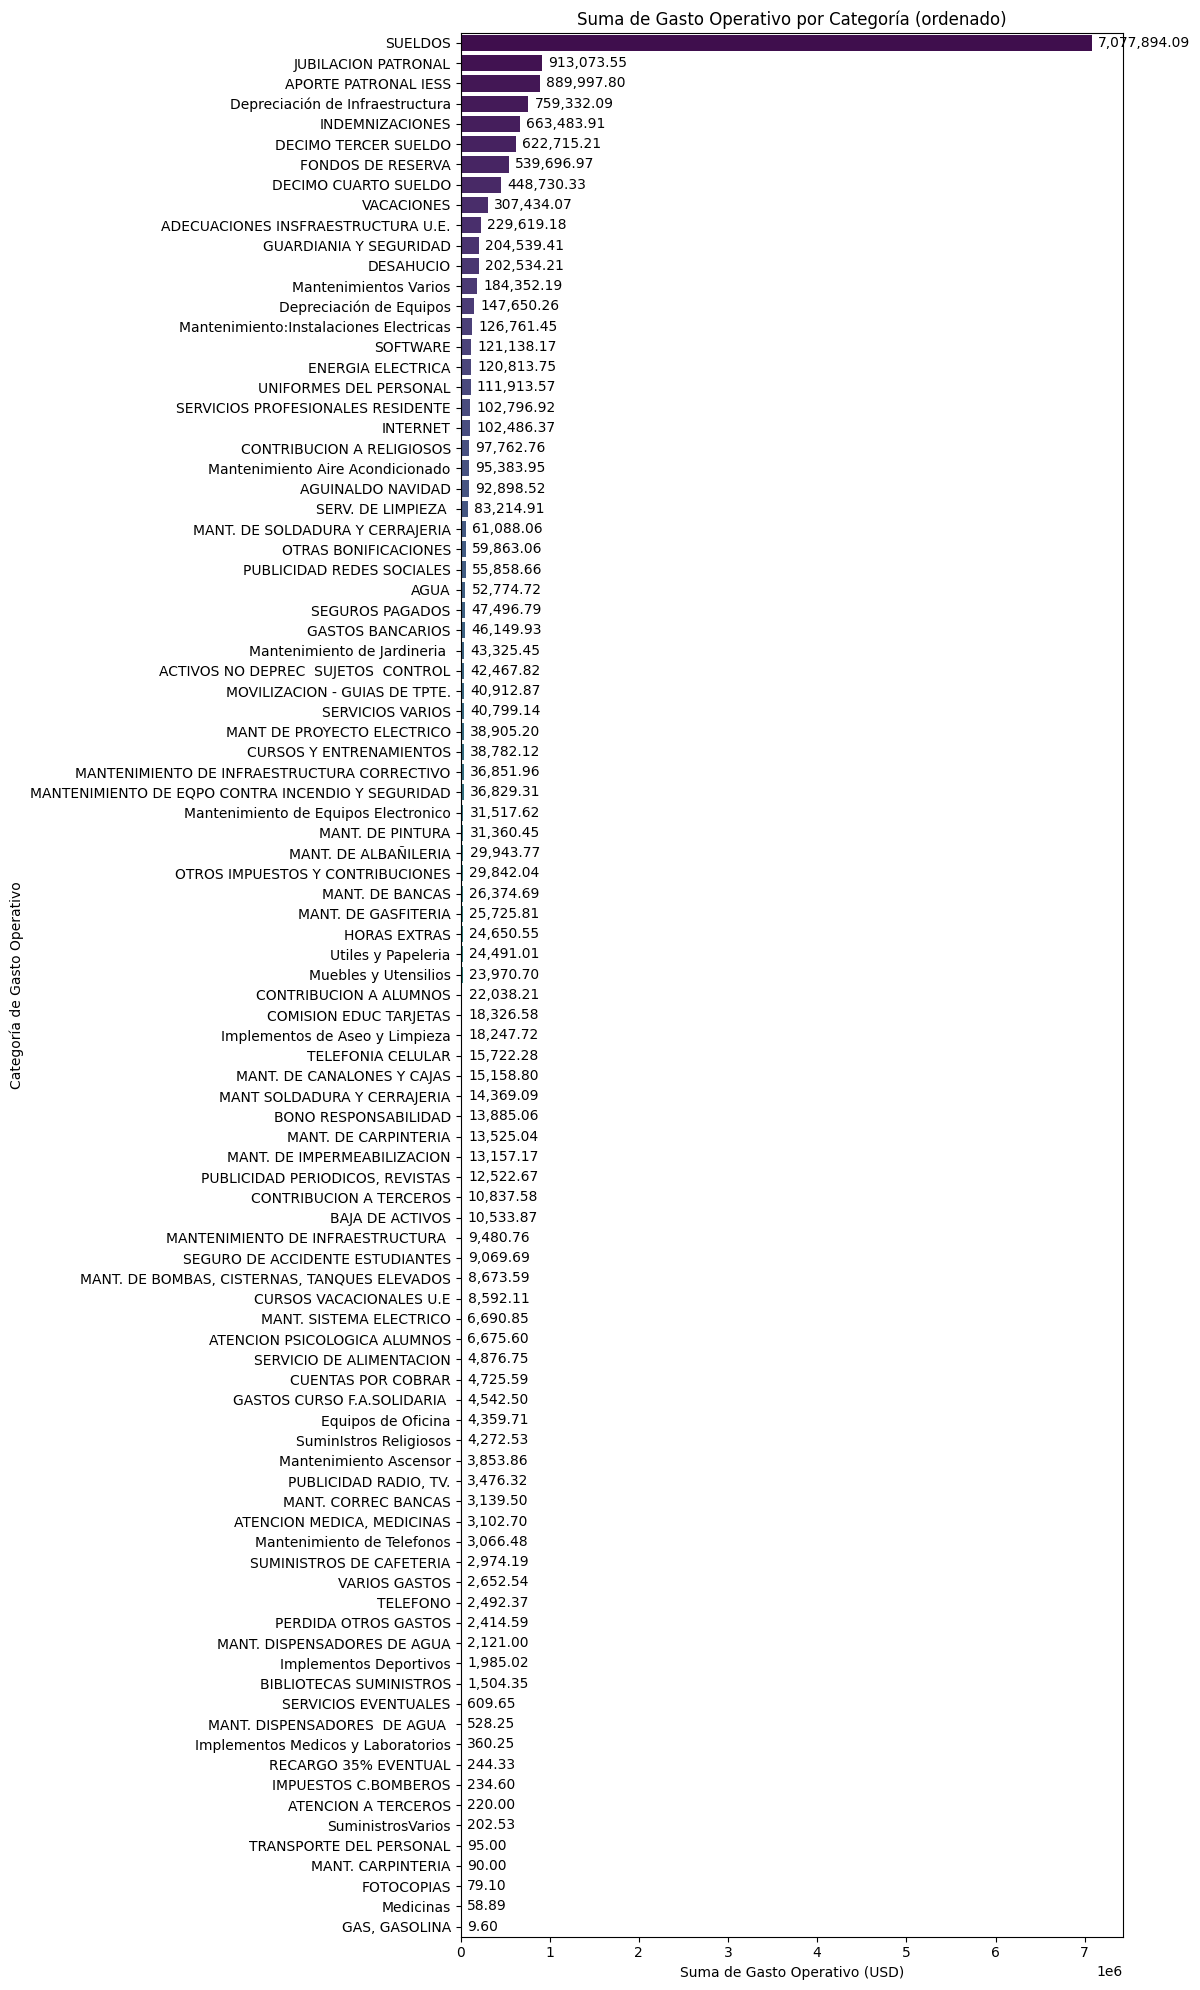

In [33]:

# Calcular suma de gasto operativo por categoría y ordenar desc
gasto_suma = df.groupby('gasto_operativo_nombre')['gasto_operativo_valor'].sum().sort_values(ascending=False)

# Convertir a DataFrame para seaborn
gasto_suma_df = gasto_suma.reset_index()

plt.figure(figsize=(12, 20))
ax = sns.barplot(
    data=gasto_suma_df,
    y='gasto_operativo_nombre',
    x='gasto_operativo_valor',
    order=gasto_suma_df['gasto_operativo_nombre'],
    palette='viridis'
)

plt.title('Suma de Gasto Operativo por Categoría (ordenado)')
plt.xlabel('Suma de Gasto Operativo (USD)')
plt.ylabel('Categoría de Gasto Operativo')

# Agregar etiquetas con los valores al lado derecho de las barras
for i, v in enumerate(gasto_suma_df['gasto_operativo_valor']):
    ax.text(v + max(gasto_suma_df['gasto_operativo_valor']) * 0.01, i, f'{v:,.2f}', va='center')

plt.tight_layout()
plt.show()


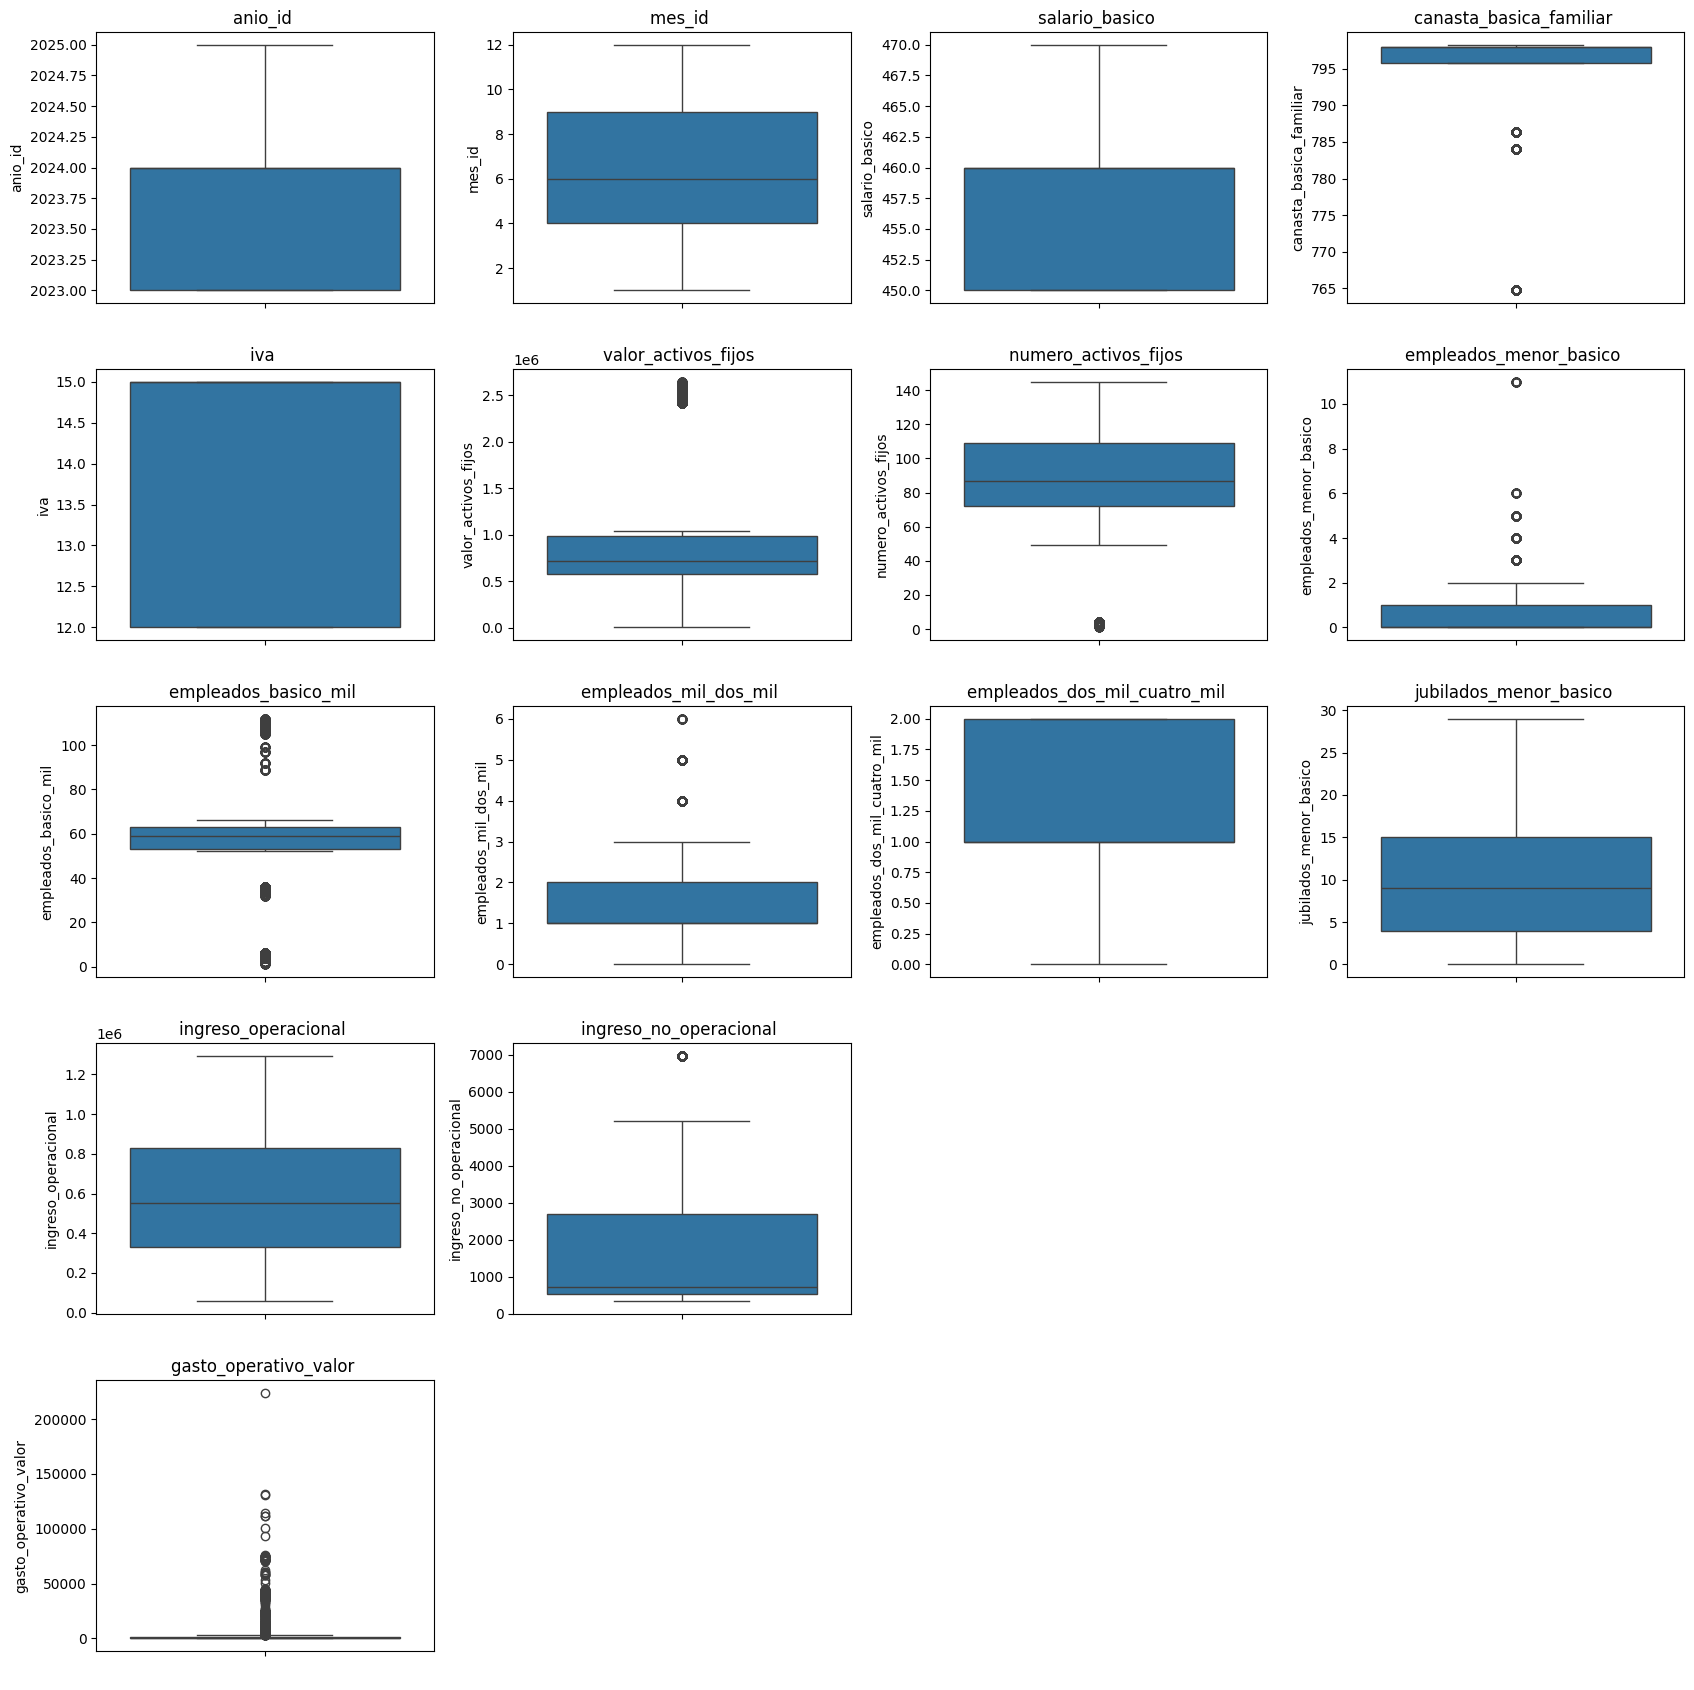

In [34]:
plt.figure(figsize=(17, 17))
for i, feature in enumerate(df.columns):
    if(feature == "gasto_operativo" or feature == "gasto_operativo_nombre"):
        continue
    plt.subplot(5, 4, i+1)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} ')
    plt.xlabel(' ')
    plt.ylabel(feature)
plt.tight_layout()

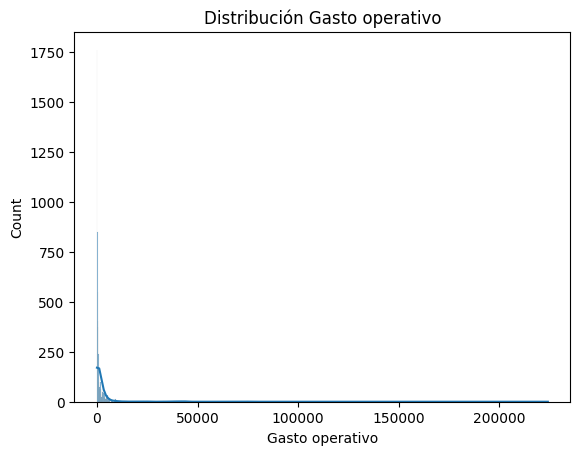

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.histplot(data=df, x='gasto_operativo_valor', kde=True,ax=ax)
ax.set_title("Distribución Gasto operativo")
ax.set_xlabel('Gasto operativo');

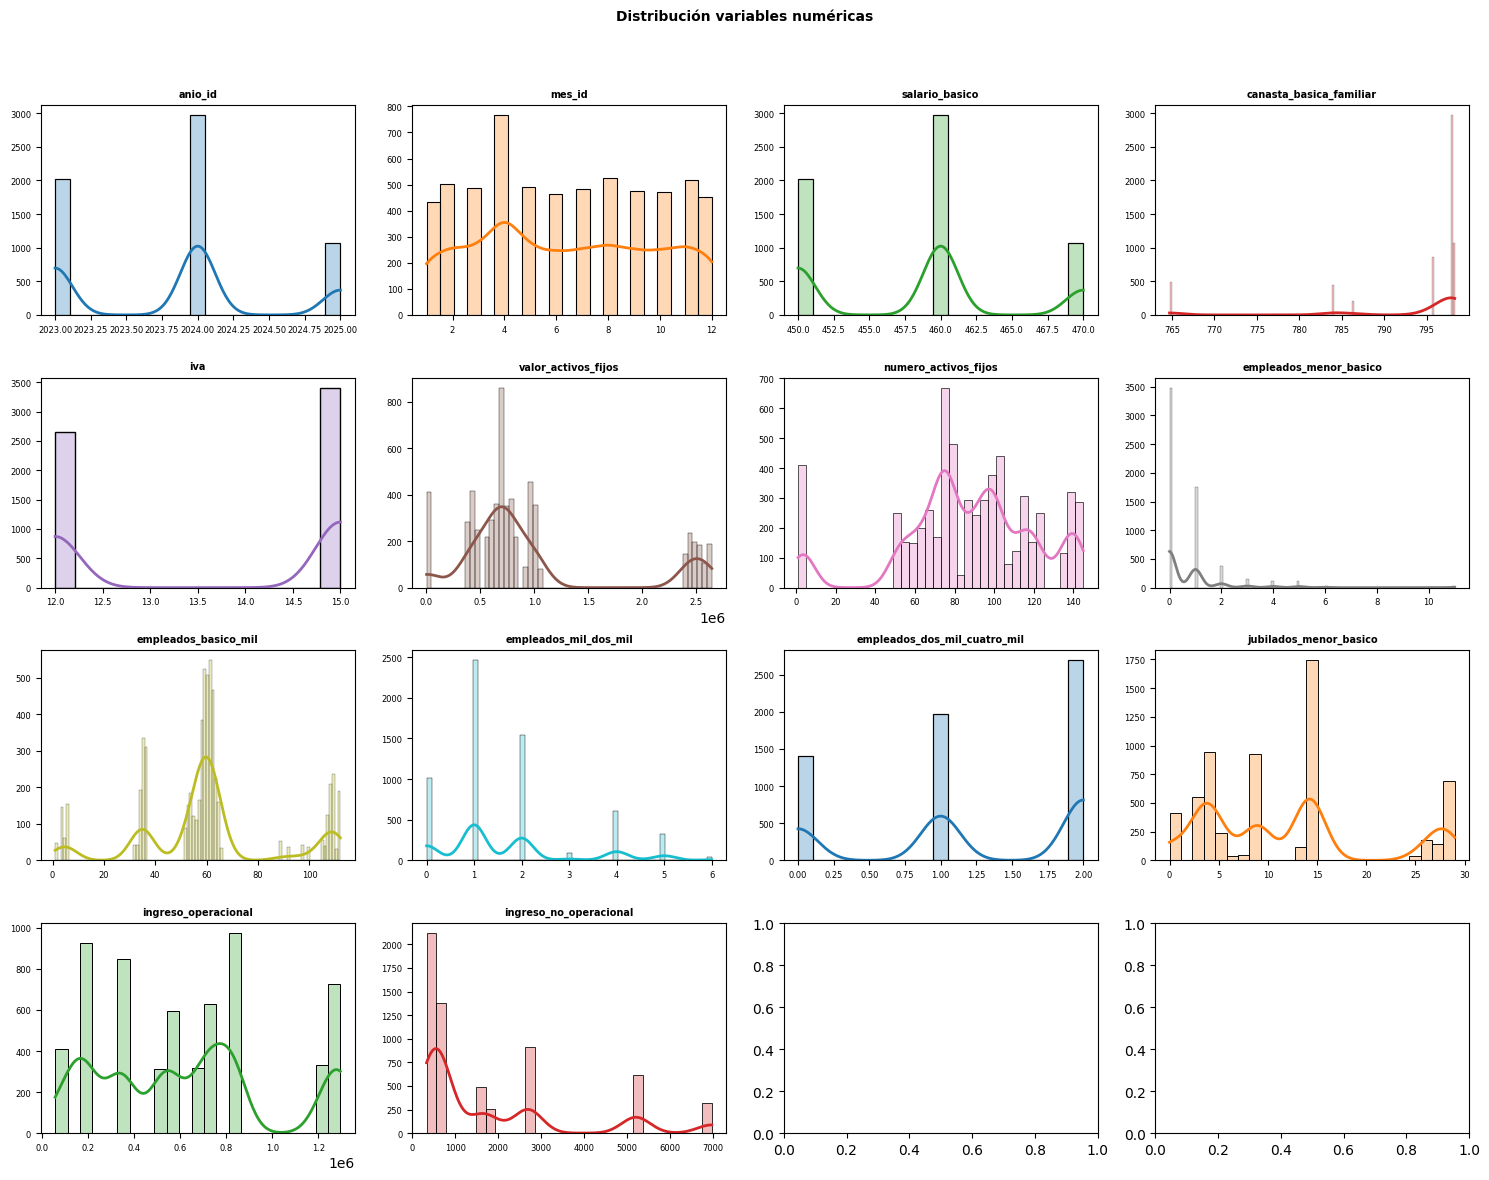

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('gasto_operativo_valor')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [37]:
df.isnull().any()

anio_id                         False
mes_id                          False
salario_basico                  False
canasta_basica_familiar         False
iva                             False
valor_activos_fijos             False
numero_activos_fijos            False
empleados_menor_basico          False
empleados_basico_mil            False
empleados_mil_dos_mil           False
empleados_dos_mil_cuatro_mil    False
jubilados_menor_basico          False
ingreso_operacional             False
ingreso_no_operacional          False
gasto_operativo                 False
gasto_operativo_nombre          False
gasto_operativo_valor           False
dtype: bool

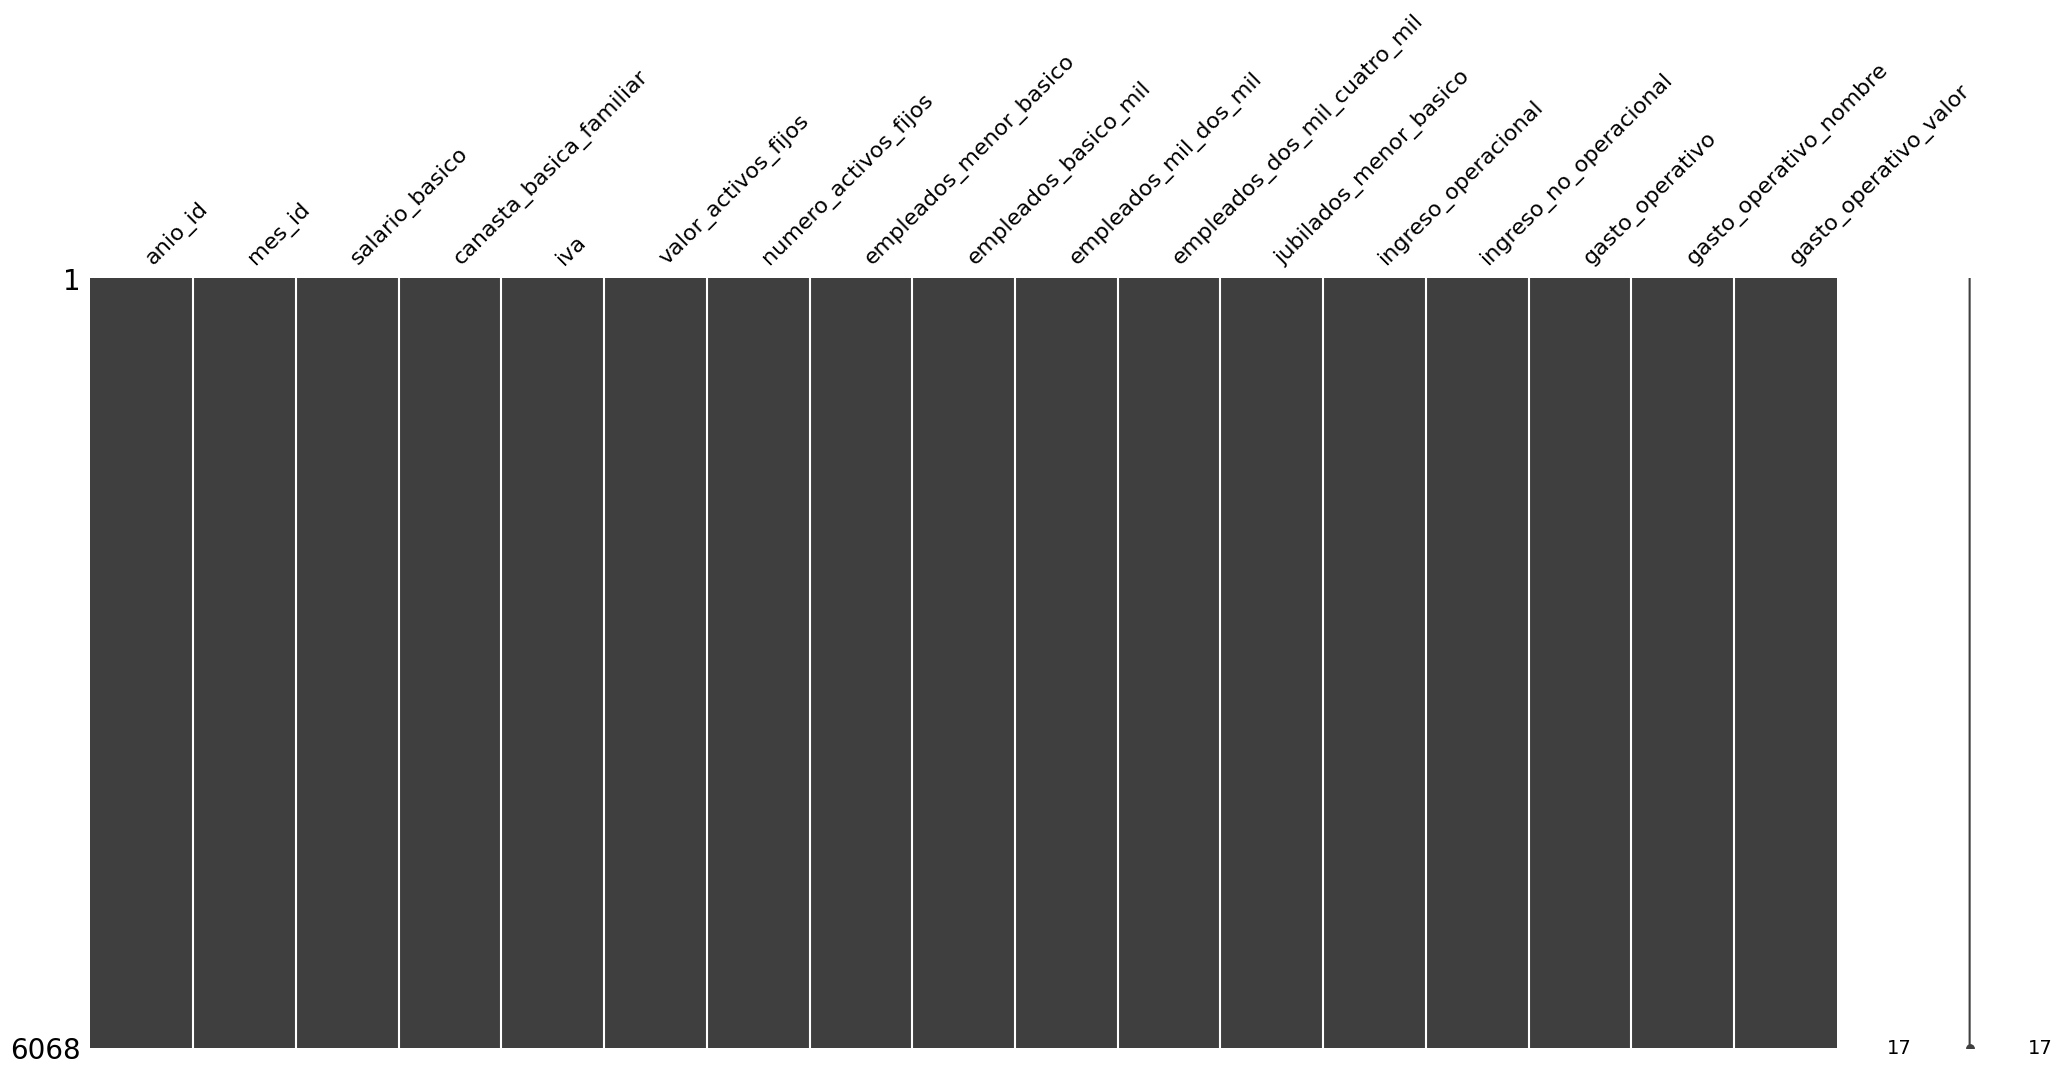

In [40]:
# Visualizamos el patrón de valores nulos
msno.matrix(df)
plt.show()

In [41]:
'''
sns.pairplot(data=df,vars=("anio_id","mes_id","salario_basico", \
                                       "iva","valor_activos_fijos","numero_activos_fijos", \
                                       "empleados_menor_basico","empleados_basico_mil","empleados_mil_dos_mil",\
                                       "empleados_dos_mil_cuatro_mil","jubilados_menor_basico","ingreso_operacional",\
                                       "ingreso_no_operacional"),hue="gasto_operativo_valor")
plt.show()
'''

'\nsns.pairplot(data=df,vars=("anio_id","mes_id","salario_basico",                                        "iva","valor_activos_fijos","numero_activos_fijos",                                        "empleados_menor_basico","empleados_basico_mil","empleados_mil_dos_mil",                                       "empleados_dos_mil_cuatro_mil","jubilados_menor_basico","ingreso_operacional",                                       "ingreso_no_operacional"),hue="gasto_operativo_valor")\nplt.show()\n'

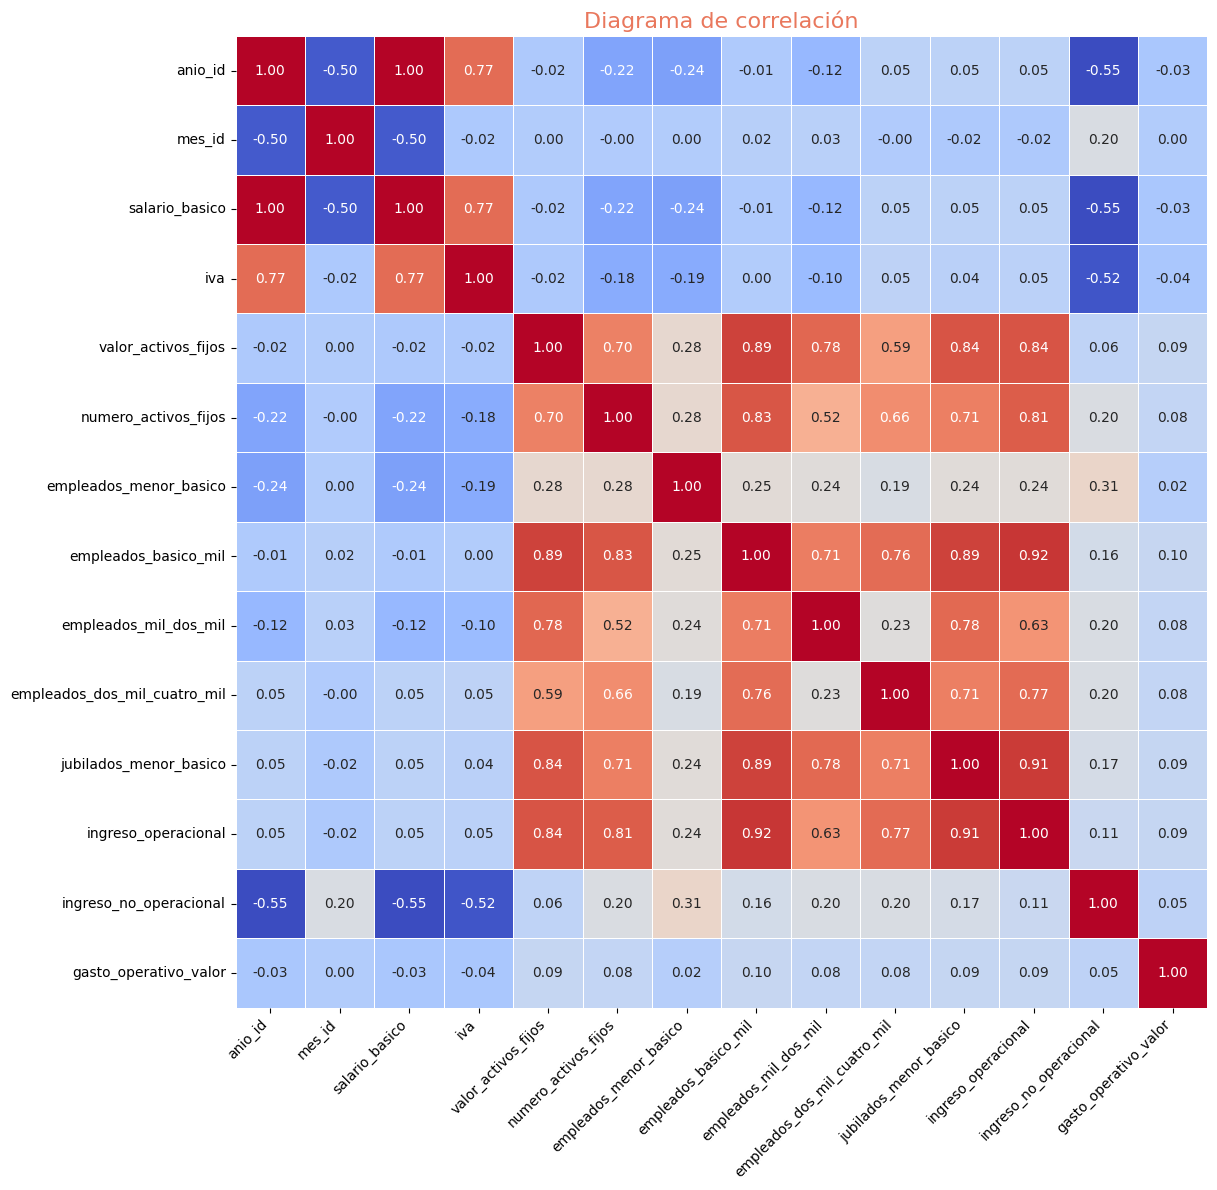

In [42]:
columnas = ["anio_id", "mes_id", "salario_basico", 
            "iva", "valor_activos_fijos", "numero_activos_fijos", 
            "empleados_menor_basico", "empleados_basico_mil", "empleados_mil_dos_mil",
            "empleados_dos_mil_cuatro_mil", "jubilados_menor_basico", "ingreso_operacional",
            "ingreso_no_operacional", "gasto_operativo_valor"]

# Calculamos la correlación
corr = np.corrcoef(df[columnas].values.T)

# Tamaño más grande del gráfico
plt.figure(figsize=(16, 12))

# Mapa de calor
sns.heatmap(
    corr, 
    xticklabels=columnas, 
    yticklabels=columnas, 
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f',
    cbar=False,
    square=True,
    annot_kws={'size': 10},
    linewidth=.5
)

plt.title('Diagrama de correlación', color='#E9785D', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [43]:
df = df.drop(columns=['gasto_operativo_nombre']) 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   anio_id                       6068 non-null   int64   
 1   mes_id                        6068 non-null   int64   
 2   salario_basico                6068 non-null   int64   
 3   canasta_basica_familiar       6068 non-null   float64 
 4   iva                           6068 non-null   int64   
 5   valor_activos_fijos           6068 non-null   float64 
 6   numero_activos_fijos          6068 non-null   int64   
 7   empleados_menor_basico        6068 non-null   int64   
 8   empleados_basico_mil          6068 non-null   int64   
 9   empleados_mil_dos_mil         6068 non-null   int64   
 10  empleados_dos_mil_cuatro_mil  6068 non-null   int64   
 11  jubilados_menor_basico        6068 non-null   int64   
 12  ingreso_operacional           6068 non-null   fl

### 1. Preparación de los datos

In [49]:
# Separar X e y
X = df.drop(columns=['gasto_operativo_valor'])
y = df['gasto_operativo_valor']

In [50]:
# Dividimos: primero train+valid (85%) y test (15%)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [51]:
# Dividimos train_valid en train (70%) y valid (15%)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1765, random_state=42)

In [52]:
print(f'Tamaño entrenamiento: {X_train.shape[0]}')
print(f'Tamaño validación: {X_valid.shape[0]}')
print(f'Tamaño test: {X_test.shape[0]}')

Tamaño entrenamiento: 4246
Tamaño validación: 911
Tamaño test: 911


In [53]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4246 entries, 4117 to 1553
Series name: gasto_operativo_valor
Non-Null Count  Dtype  
--------------  -----  
4246 non-null   float64
dtypes: float64(1)
memory usage: 66.3 KB


#### 1.1 Función para obtener las métricas

In [56]:
def calcular_metricas(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

### 2. Procesamiento de los datos

In [58]:
# Columnas por tipo de transformación
standard_cols = [
    'anio_id', 'salario_basico', 'canasta_basica_familiar',
    'numero_activos_fijos', 'empleados_menor_basico', 'empleados_basico_mil',
    'empleados_mil_dos_mil', 'empleados_dos_mil_cuatro_mil',
    'jubilados_menor_basico'
]

robust_cols = ['valor_activos_fijos', 'ingreso_operacional', 'ingreso_no_operacional']

onehot_cols = ['mes_id', 'iva']

target_col = 'gasto_operativo'

<h4>2.1. Target Encoding</h4>

In [61]:
te = TargetEncoder()
te.fit(X_train[[target_col]], y_train)

X_train_te = te.transform(X_train[[target_col]])
X_valid_te = te.transform(X_valid[[target_col]])
X_test_te  = te.transform(X_test[[target_col]])

#### 2.2. One Hot Encoding

In [63]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[onehot_cols])

X_train_ohe = ohe.transform(X_train[onehot_cols])
X_valid_ohe = ohe.transform(X_valid[onehot_cols])
X_test_ohe  = ohe.transform(X_test[onehot_cols])

#### 2.3. Standard Scaler

In [65]:
scaler_std = StandardScaler()
scaler_std.fit(X_train[standard_cols])

X_train_std = scaler_std.transform(X_train[standard_cols])
X_valid_std = scaler_std.transform(X_valid[standard_cols])
X_test_std  = scaler_std.transform(X_test[standard_cols])

#### 2.4. Robust Scaler

In [67]:
scaler_rob = RobustScaler()
scaler_rob.fit(X_train[robust_cols])

X_train_rob = scaler_rob.transform(X_train[robust_cols])
X_valid_rob = scaler_rob.transform(X_valid[robust_cols])
X_test_rob  = scaler_rob.transform(X_test[robust_cols])

### 3. Eliminar columnas originales ya codificadas

In [69]:
drop_cols = onehot_cols + [target_col]

X_train_base = X_train.drop(columns=drop_cols).copy()
X_valid_base = X_valid.drop(columns=drop_cols).copy()
X_test_base  = X_test.drop(columns=drop_cols).copy()

### 4. Reconstruir DataFrames combinados, entrenamiento, validación y test

#### 4.1 Reconstrucción de datos para manejar Regresión Lineal 

In [72]:
X_train_proc = pd.DataFrame(X_train_std, columns=standard_cols, index=X_train.index)
X_train_proc = pd.concat([
    X_train_proc,
    pd.DataFrame(X_train_rob, columns=robust_cols, index=X_train.index),
    pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(onehot_cols), index=X_train.index),
    X_train_te.set_index(X_train.index)
], axis=1)

X_valid_proc = pd.DataFrame(X_valid_std, columns=standard_cols, index=X_valid.index)
X_valid_proc = pd.concat([
    X_valid_proc,
    pd.DataFrame(X_valid_rob, columns=robust_cols, index=X_valid.index),
    pd.DataFrame(X_valid_ohe, columns=ohe.get_feature_names_out(onehot_cols), index=X_valid.index),
    X_valid_te.set_index(X_valid.index)
], axis=1)

X_test_proc = pd.DataFrame(X_test_std, columns=standard_cols, index=X_test.index)
X_test_proc = pd.concat([
    X_test_proc,
    pd.DataFrame(X_test_rob, columns=robust_cols, index=X_test.index),
    pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(onehot_cols), index=X_test.index),
    X_test_te.set_index(X_test.index)
], axis=1)

In [73]:
X_train_proc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4246 entries, 4117 to 1553
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   anio_id                       4246 non-null   float64
 1   salario_basico                4246 non-null   float64
 2   canasta_basica_familiar       4246 non-null   float64
 3   numero_activos_fijos          4246 non-null   float64
 4   empleados_menor_basico        4246 non-null   float64
 5   empleados_basico_mil          4246 non-null   float64
 6   empleados_mil_dos_mil         4246 non-null   float64
 7   empleados_dos_mil_cuatro_mil  4246 non-null   float64
 8   jubilados_menor_basico        4246 non-null   float64
 9   valor_activos_fijos           4246 non-null   float64
 10  ingreso_operacional           4246 non-null   float64
 11  ingreso_no_operacional        4246 non-null   float64
 12  mes_id_1                      4246 non-null   float64
 13  mes_i

#### 4.2 Reconstrucción de datos para manejar Árboles de decisión (DecisionTree, RandomForest, Xgboost)

In [77]:
# 1. Extraer solo las columnas escaladas con StandardScaler (en el mismo orden)
X_train_std_scaled = X_train_proc[standard_cols]
X_valid_std_scaled = X_valid_proc[standard_cols]
X_test_std_scaled  = X_test_proc[standard_cols]

# 2. Hacer inverse_transform
X_train_std_original = scaler_std.inverse_transform(X_train_std_scaled)
X_valid_std_original = scaler_std.inverse_transform(X_valid_std_scaled)
X_test_std_original  = scaler_std.inverse_transform(X_test_std_scaled)

# 3. Obtener la columna anio_id (en base a la posición en standard_cols)
anio_index = standard_cols.index('anio_id')

anio_train_original = X_train_std_original[:, anio_index]
anio_valid_original = X_valid_std_original[:, anio_index]
anio_test_original  = X_test_std_original[:, anio_index]

In [78]:
X_train_tree = X_train_proc.copy()
X_valid_tree = X_valid_proc.copy()
X_test_tree  = X_test_proc.copy()

X_train_tree['anio_id'] = anio_train_original
X_valid_tree['anio_id'] = anio_valid_original
X_test_tree['anio_id']  = anio_test_original

#### 4.3 Reconstrucción de datos para manejar Redes neuronales artificiales

In [82]:
# Copiamos los datasets para RNA
X_train_rna = X_train_proc.copy()
X_valid_rna = X_valid_proc.copy()
X_test_rna  = X_test_proc.copy()

# Inicializar escalador para variable target-encoded de gasto_operativo
gasto_operativo_scaler = RobustScaler()

# Escalar la columna target-encoded
X_train_scaled = gasto_operativo_scaler.fit_transform(X_train_rna[[target_col]])
X_valid_scaled = gasto_operativo_scaler.transform(X_valid_rna[[target_col]])
X_test_scaled  = gasto_operativo_scaler.transform(X_test_rna[[target_col]])

# Reemplazar en los datasets
X_train_rna[target_col] = X_train_scaled
X_valid_rna[target_col] = X_valid_scaled
X_test_rna[target_col]  = X_test_scaled

In [86]:
# Escalar el para la variable objetivo
target_rna = RobustScaler()
y_train_rna = target_rna.fit_transform(y_train.values.reshape(-1, 1))
y_valid_rna = target_rna.transform(y_valid.values.reshape(-1, 1))
y_test_rna = target_rna.transform(y_test.values.reshape(-1, 1))

### 5. Entrenar modelos

#### 5.1. Regresión Lineal

##### 5.1.1. Entrenamiento

In [109]:
model_lr = LinearRegression()

# Definimos los hiperparámetros a buscar
param_grid = {
    'fit_intercept': [True, False]
}

# Definimos validación cruzada con KFold (5 divisiones)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV para buscar la mejor parametrización
grid_search = GridSearchCV(model_lr, param_grid, cv=cv, scoring='r2')
grid_search.fit(X_train_proc, y_train)

# Obtenemos el mejor resultado
best_lr = grid_search.best_estimator_
print(f"Mejor fit_intercept: {grid_search.best_params_['fit_intercept']}")

Mejor fit_intercept: True


##### 5.1.2. Predicciones

In [111]:
y_train_pred_lr = best_lr.predict(X_train_proc)
y_valid_pred_rl = best_lr.predict(X_valid_proc)
y_test_pred_rl = best_lr.predict(X_test_proc)

##### 5.1.3. Métricas

In [113]:
r2_train_lr, mae_train_lr, rmse_train_lr = calcular_metricas(y_train, y_train_pred_lr)
r2_valid_lr, mae_valid_lr, rmse_valid_lr = calcular_metricas(y_valid, y_valid_pred_rl)
r2_test_lr, mae_test_lr, rmse_test_lr = calcular_metricas(y_test, y_test_pred_rl)

print("Regresión lineal:")
print(f"Entrenamiento → R²: {r2_train_lr:.3f}, MAE: {mae_train_lr:.2f}, RMSE: {rmse_train_lr:.2f}")
print(f"Validación    → R²: {r2_valid_lr:.3f}, MAE: {mae_valid_lr:.2f}, RMSE: {rmse_valid_lr:.2f}")
print(f"Test          → R²: {r2_test_lr:.3f}, MAE: {mae_test_lr:.2f}, RMSE: {rmse_test_lr:.2f}")

Regresión lineal:
Entrenamiento → R²: 0.623, MAE: 1880.72, RMSE: 5113.86
Validación    → R²: 0.511, MAE: 2216.46, RMSE: 8567.97
Test          → R²: 0.722, MAE: 1773.99, RMSE: 4333.94


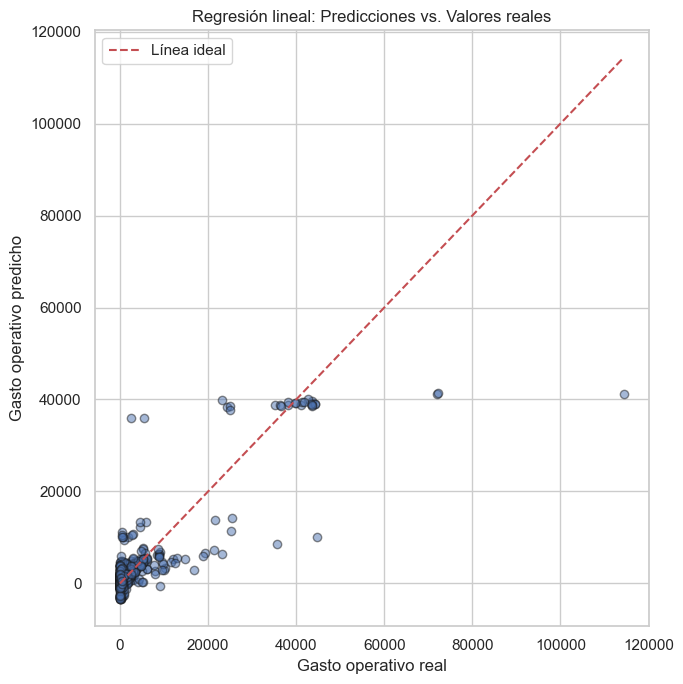

In [536]:
# Gráfico de dispersión
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_rl, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Línea ideal')

plt.xlabel('Gasto operativo real')
plt.ylabel('Gasto operativo predicho')
plt.title('Regresión lineal: Predicciones vs. Valores reales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

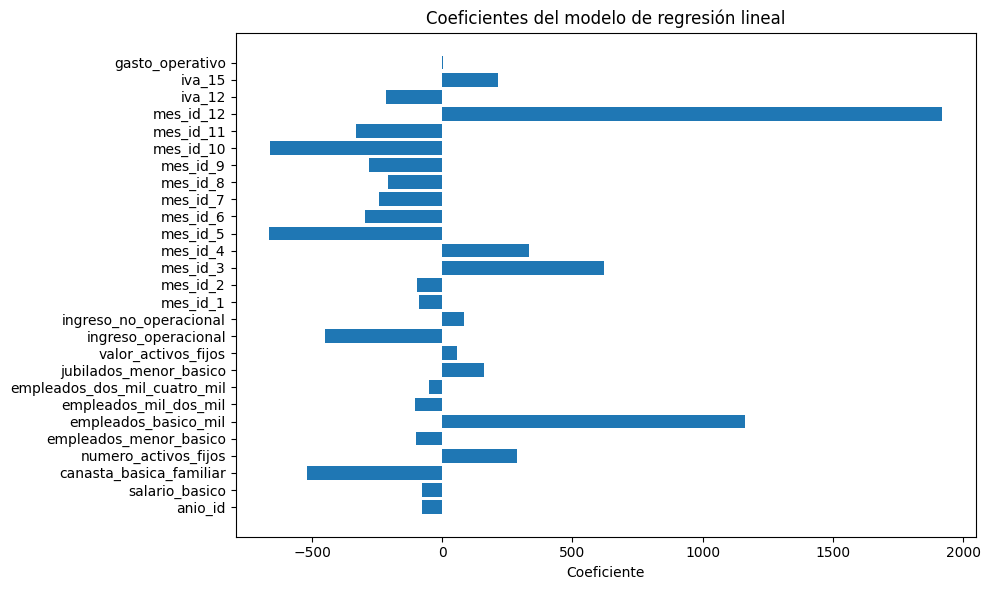

In [115]:
coefs = best_lr.coef_
features = X_train_proc.columns

plt.figure(figsize=(10,6))
plt.barh(features, coefs)
plt.xlabel('Coeficiente')
plt.title('Coeficientes del modelo de regresión lineal')
plt.tight_layout()
plt.show()

#### 5.2. Decision tree

##### 5.2.1. Curva de aprendizaje de la profundidad del árbol

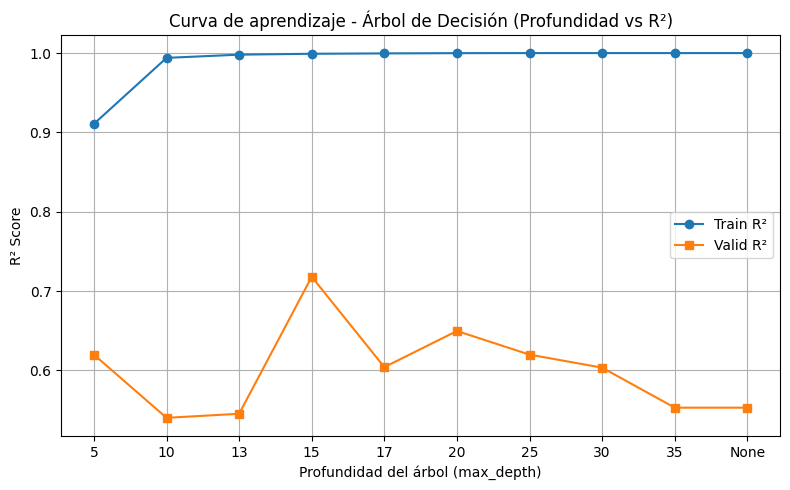

In [123]:
depths = [5, 10, 13, 15, 17, 20, 25, 30, 35, None]
train_scores = []
valid_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train_tree, y_train)
    
    train_r2 = model.score(X_train_tree, y_train)
    valid_r2 = model.score(X_valid_tree, y_valid)
    
    train_scores.append(train_r2)
    valid_scores.append(valid_r2)

# Reemplazar None por un valor simbólico en el gráfico
depth_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure(figsize=(8, 5))
plt.plot(depth_labels, train_scores, label='Train R²', marker='o')
plt.plot(depth_labels, valid_scores, label='Valid R²', marker='s')
plt.xlabel('Profundidad del árbol (max_depth)')
plt.ylabel('R² Score')
plt.title('Curva de aprendizaje - Árbol de Decisión (Profundidad vs R²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 5.2.2. Entrenamiento

In [125]:
# Crear y entrenar el modelo
model_dt = DecisionTreeRegressor(random_state=42)

# Definimos los hiperparámetros a buscar
param_grid = {
    'max_depth': [5, 8, 10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4, 5, 8, 10]
}

# Definimos validación cruzada con KFold (5 divisiones)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV para buscar la mejor parametrización
grid_search = GridSearchCV(
    estimator=model_dt, 
    param_grid=param_grid,
    cv=cv, 
    scoring='r2', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train_tree, y_train)

# Obtenemos el mejor resultado
best_dt = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}


##### 5.2.3. Predicciones

In [128]:
y_train_pred_dt = best_dt.predict(X_train_tree)
y_valid_pred_dt = best_dt.predict(X_valid_tree)
y_test_pred_dt = best_dt.predict(X_test_tree)

##### 5.2.4. Métricas

In [130]:
r2_train_dt, mae_train_dt, rmse_train_dt = calcular_metricas(y_train, y_train_pred_dt)
r2_valid_dt, mae_valid_dt, rmse_valid_dt = calcular_metricas(y_valid, y_valid_pred_dt)
r2_test_dt, mae_test_dt, rmse_test_dt = calcular_metricas(y_test, y_test_pred_dt)

print("Decision tree:")
print(f"Entrenamiento → R²: {r2_train_dt:.3f}, MAE: {mae_train_dt:.2f}, RMSE: {rmse_train_dt:.2f}")
print(f"Validación    → R²: {r2_valid_dt:.3f}, MAE: {mae_valid_dt:.2f}, RMSE: {rmse_valid_dt:.2f}")
print(f"Test          → R²: {r2_test_dt:.3f}, MAE: {mae_test_dt:.2f}, RMSE: {rmse_test_dt:.2f}")

Decision tree:
Entrenamiento → R²: 0.933, MAE: 511.64, RMSE: 2149.05
Validación    → R²: 0.686, MAE: 1040.56, RMSE: 6867.38
Test          → R²: 0.862, MAE: 745.65, RMSE: 3059.46


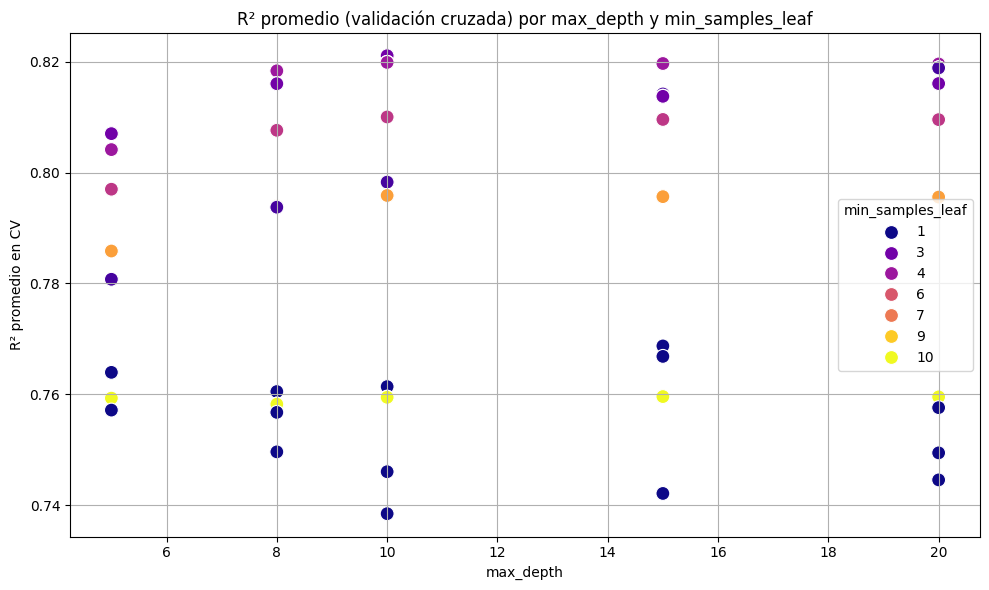

In [131]:
# Convertir resultados a DataFrame
dt_results_df = pd.DataFrame(grid_search.cv_results_)

# Ordenar por R² promedio
dt_results_df = dt_results_df.sort_values(by='mean_test_score', ascending=False)

# Graficar: comparación de R² promedio según max_depth y min_samples_leaf
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dt_results_df,
    x='param_max_depth',
    y='mean_test_score',
    hue='param_min_samples_leaf',
    palette='plasma',
    s=100
)
plt.title('R² promedio (validación cruzada) por max_depth y min_samples_leaf')
plt.xlabel('max_depth')
plt.ylabel('R² promedio en CV')
plt.legend(title='min_samples_leaf')
plt.grid(True)
plt.tight_layout()
plt.show()


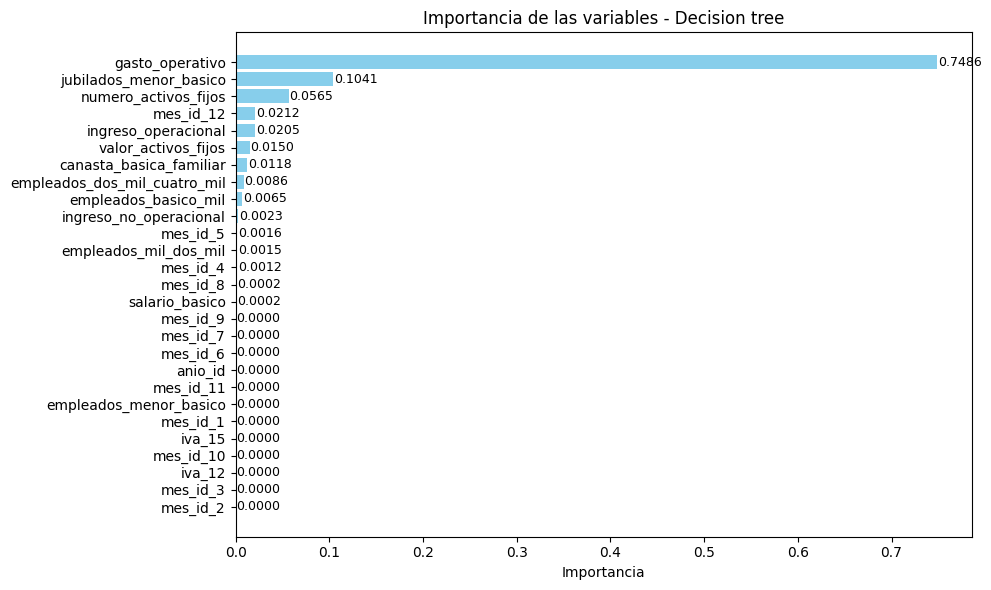

In [132]:
# Obtener importancias y nombres de features
importances = best_dt.feature_importances_
features = X_train_tree.columns
indices = np.argsort(importances)  # ordenar de menor a mayor

# Ordenar variables e importancias para graficar de forma ordenada
features_sorted = np.array(features)[indices]
importances_sorted = importances[indices]

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, importances_sorted, color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las variables - Decision tree')

# Añadir valores al final de cada barra
for bar, value in zip(bars, importances_sorted):
    plt.text(value + 0.001, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

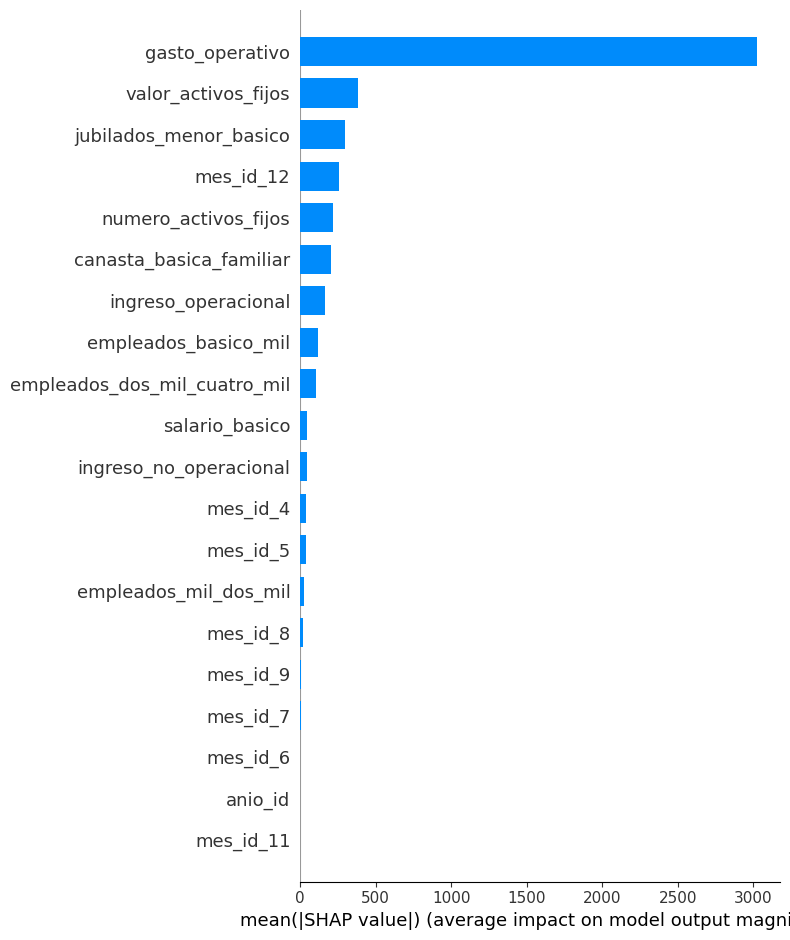

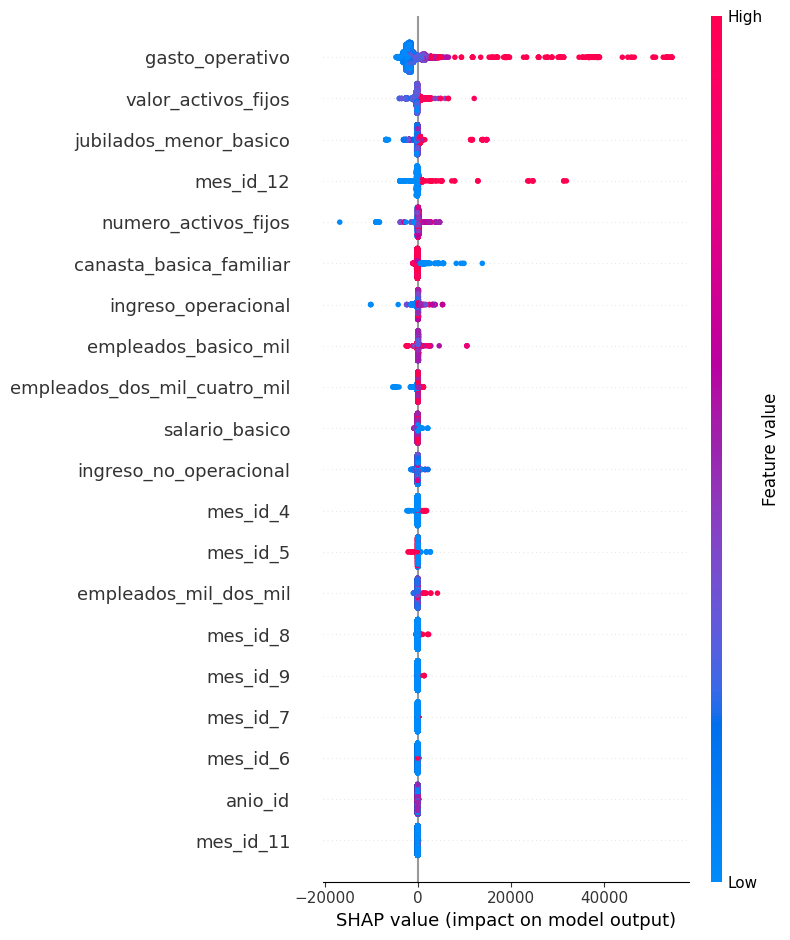

In [357]:
shap.initjs()
explainer = shap.TreeExplainer(best_dt)
shap_values = explainer.shap_values(X_train_tree)

# Gráfico de resumen (tipo barra)
shap.summary_plot(shap_values, X_train_tree, plot_type="bar")

# Gráfico de resumen (tipo dot para más detalle)
shap.summary_plot(shap_values, X_train_tree)

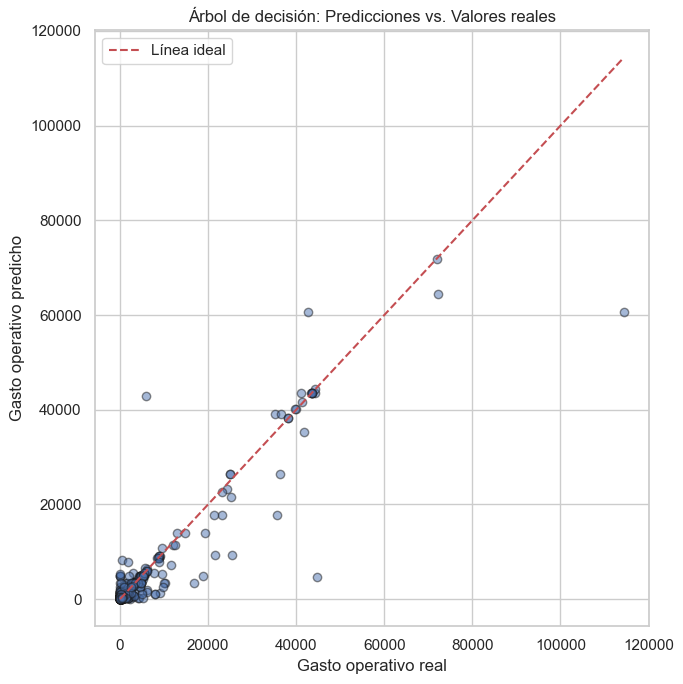

In [534]:
# Gráfico de dispersión
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_dt, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Línea ideal')

plt.xlabel('Gasto operativo real')
plt.ylabel('Gasto operativo predicho')
plt.title('Árbol de decisión: Predicciones vs. Valores reales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 5.3. Random forest

##### 5.3.1. Curva de aprendizaje de la profundidad del árbol

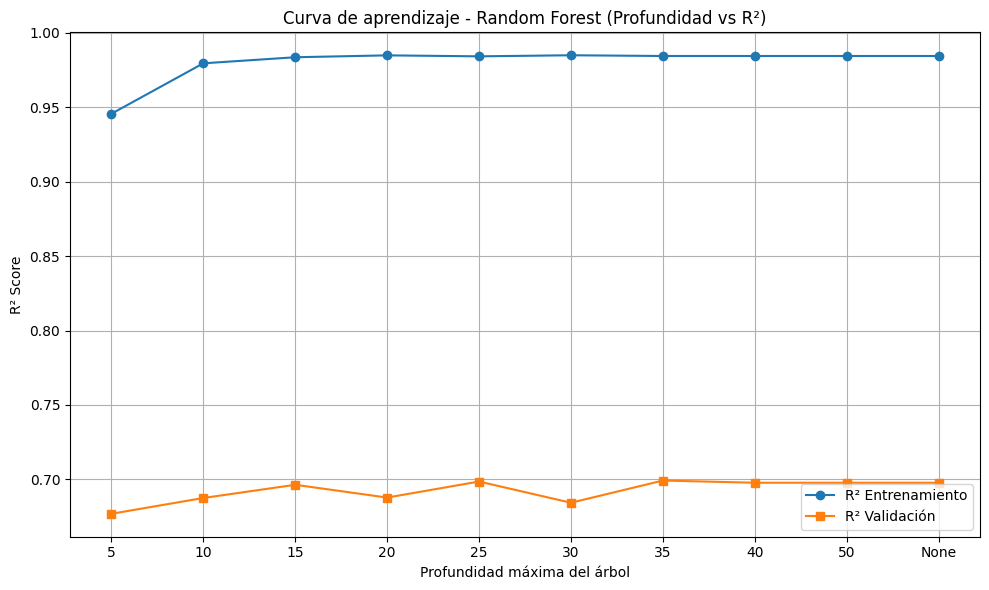

In [142]:
max_depths = [5, 10, 15, 20, 25, 30, 35, 40, 50, None]
train_scores = []
valid_scores = []

for depth in max_depths:
    rf = RandomForestRegressor(
        n_estimators=40,
        max_depth=depth,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_tree, y_train)
    
    train_r2 = rf.score(X_train_tree, y_train)
    valid_r2 = rf.score(X_valid_tree, y_valid)
    
    train_scores.append(train_r2)
    valid_scores.append(valid_r2)

# Etiquetas para eje x
depth_labels = ['None' if d is None else str(d) for d in max_depths]

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(depth_labels, train_scores, label='R² Entrenamiento', marker='o')
plt.plot(depth_labels, valid_scores, label='R² Validación', marker='s')
plt.xlabel('Profundidad máxima del árbol')
plt.ylabel('R² Score')
plt.title('Curva de aprendizaje - Random Forest (Profundidad vs R²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 5.3.2. Curva de aprendizaje número de estimadores (árboles)

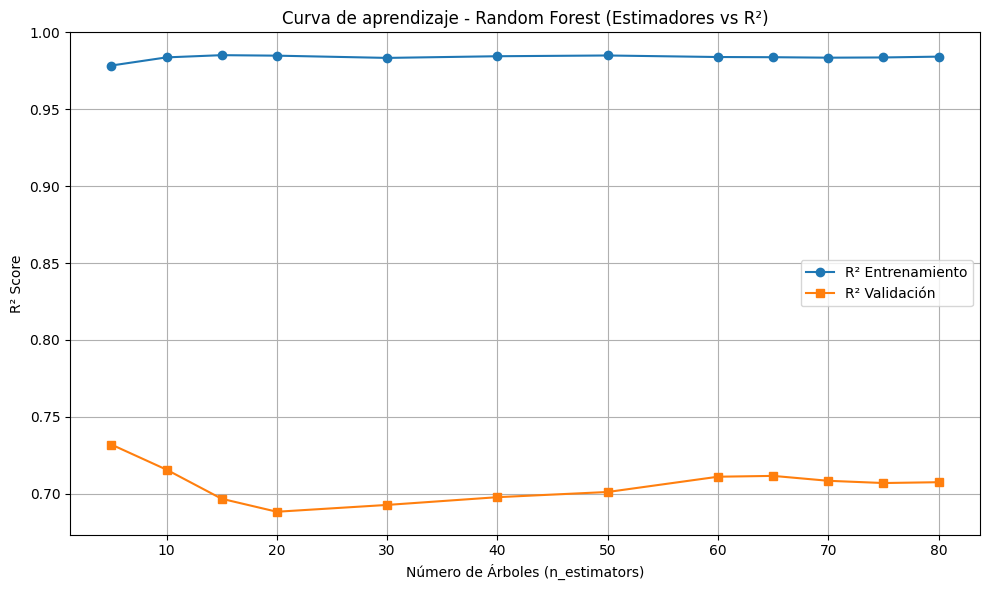

In [144]:
# Lista de n_estimators a probar
n_estimators_list = [5, 10, 15, 20, 30, 40, 50, 60, 65, 70, 75, 80]
train_scores = []
valid_scores = []

for n in n_estimators_list:
    rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=40,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train_tree, y_train)
    
    train_r2 = rf.score(X_train_tree, y_train)
    valid_r2 = rf.score(X_valid_tree, y_valid)
    
    train_scores.append(train_r2)
    valid_scores.append(valid_r2)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, train_scores, label='R² Entrenamiento', marker='o')
plt.plot(n_estimators_list, valid_scores, label='R² Validación', marker='s')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('R² Score')
plt.title('Curva de aprendizaje - Random Forest (Estimadores vs R²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 5.3.3. Entrenamiento

In [148]:
# Creamos el modelo de random forest
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Definimos los hiperparámetros a buscar
param_grid = {
    'max_depth': [12, 13, 14],
    'n_estimators': [9, 10, 15],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 3, 4]
}

# Creamos la validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_tree, y_train)


# Mejor modelo encontrado
best_rf = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros: {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


##### 5.3.4. Predicción

In [150]:
y_train_pred_rf = best_rf.predict(X_train_tree)
y_valid_pred_rf = best_rf.predict(X_valid_tree)
y_test_pred_rf = best_rf.predict(X_test_tree)

##### 5.3.5. Métricas

In [152]:
r2_train_rf, mae_train_rf, rmse_train_rf = calcular_metricas(y_train, y_train_pred_rf)
r2_valid_rf, mae_valid_rf, rmse_valid_rf = calcular_metricas(y_valid, y_valid_pred_rf)
r2_test_rf, mae_test_rf, rmse_test_rf = calcular_metricas(y_test, y_test_pred_rf)

print("Random forest:")
print(f"Entrenamiento → R²: {r2_train_rf:.3f}, MAE: {mae_train_rf:.2f}, RMSE: {rmse_train_rf:.2f}")
print(f"Validación    → R²: {r2_valid_rf:.3f}, MAE: {mae_valid_rf:.2f}, RMSE: {rmse_valid_rf:.2f}")
print(f"Test          → R²: {r2_test_rf:.3f}, MAE: {mae_test_rf:.2f}, RMSE: {rmse_test_rf:.2f}")

Random forest:
Entrenamiento → R²: 0.957, MAE: 434.63, RMSE: 1732.52
Validación    → R²: 0.716, MAE: 960.80, RMSE: 6526.83
Test          → R²: 0.884, MAE: 677.87, RMSE: 2796.17


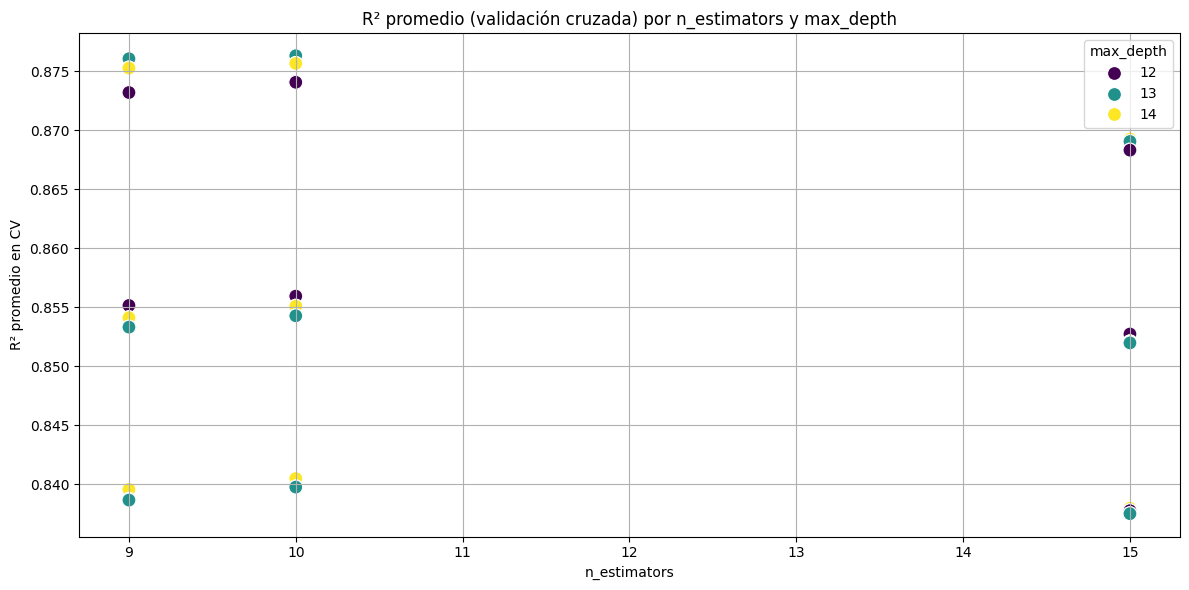

In [153]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Ordenar por por R² promedio
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Graficar: comparación de R² según n_estimators y max_depth
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_depth',
    palette='viridis',
    s=100
)
plt.title('R² promedio (validación cruzada) por n_estimators y max_depth')
plt.xlabel('n_estimators')
plt.ylabel('R² promedio en CV')
plt.legend(title='max_depth')
plt.grid(True)
plt.tight_layout()
plt.show()

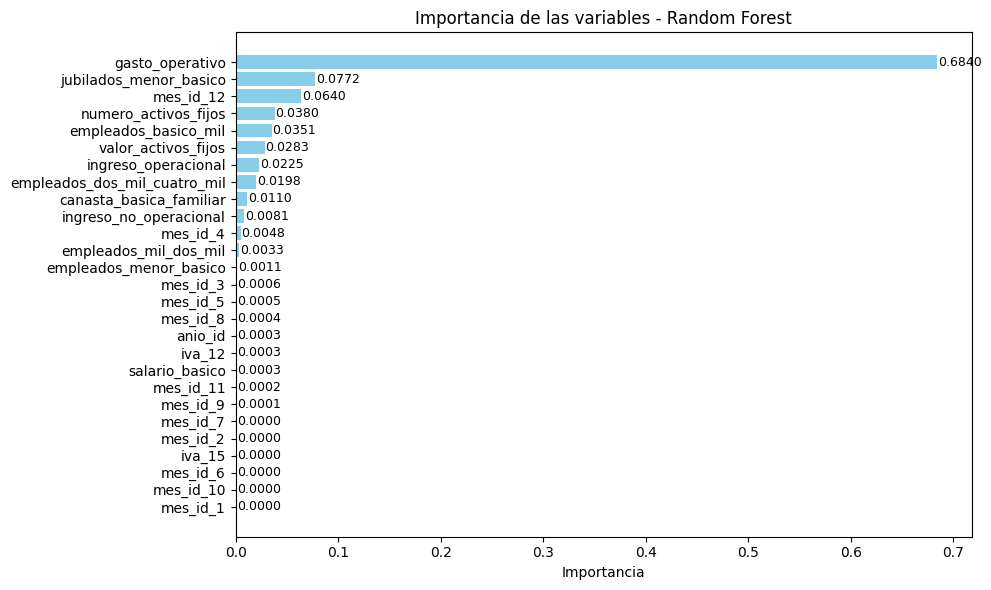

In [154]:
# Obtener importancias y nombres de features
importances = best_rf.feature_importances_
features = X_train_tree.columns
indices = np.argsort(importances)  # ordenar de menor a mayor

# Ordenar variables e importancias para graficar de forma ordenada
features_sorted = np.array(features)[indices]
importances_sorted = importances[indices]

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, importances_sorted, color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las variables - Random Forest')

# Añadir valores al final de cada barra
for bar, value in zip(bars, importances_sorted):
    plt.text(value + 0.001, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

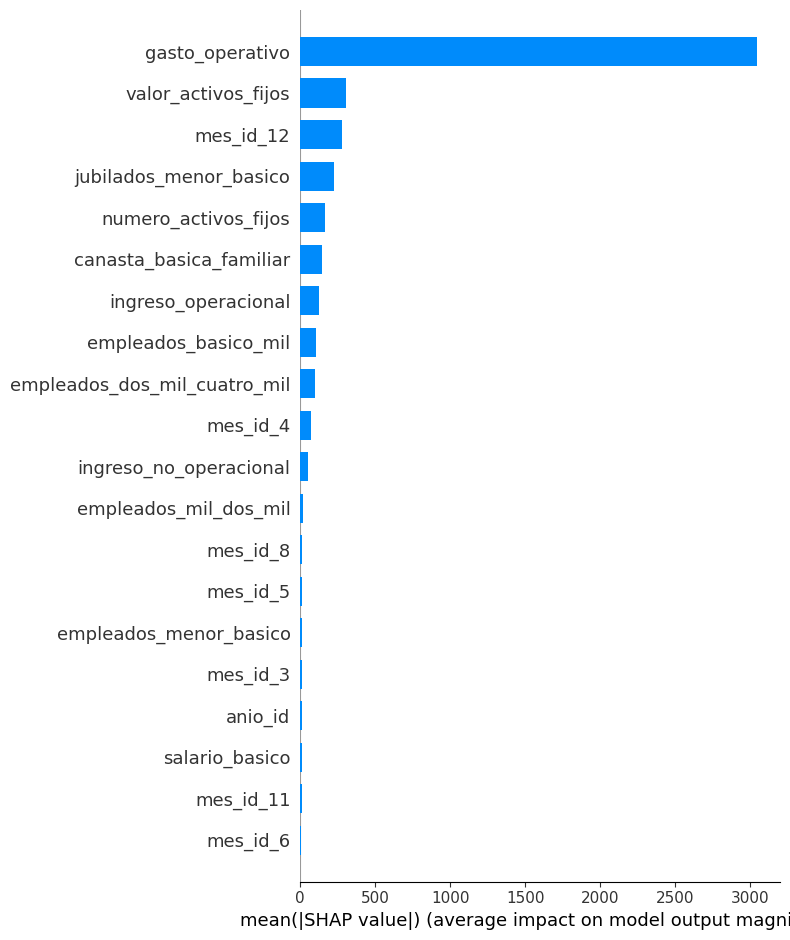

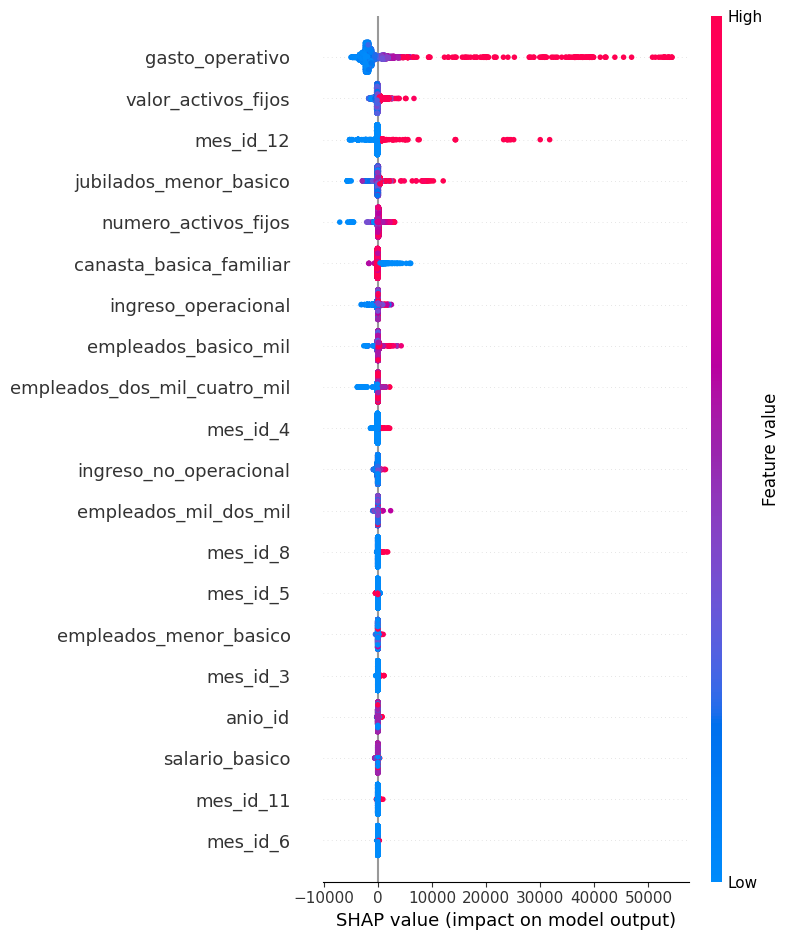

In [353]:
shap.initjs()
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_tree)

# Gráfico de resumen (tipo barra)
shap.summary_plot(shap_values, X_train_tree, plot_type="bar")

# Gráfico de resumen (tipo dot para más detalle)
shap.summary_plot(shap_values, X_train_tree)

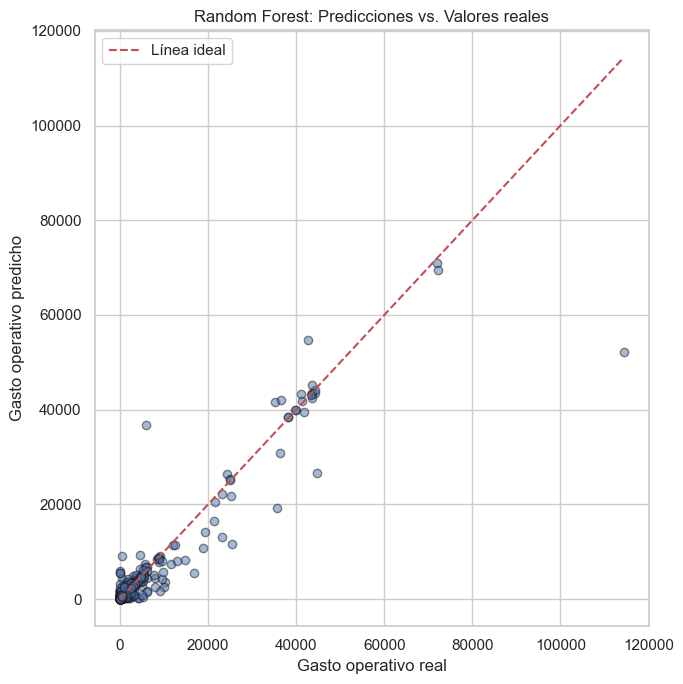

In [530]:
# Gráfico de dispersión
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Línea ideal')

plt.xlabel('Gasto operativo real')
plt.ylabel('Gasto operativo predicho')
plt.title('Random Forest: Predicciones vs. Valores reales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 5.4. XGBoost

##### 5.4.1. Curva de aprendizaje de la profundidad del árbol

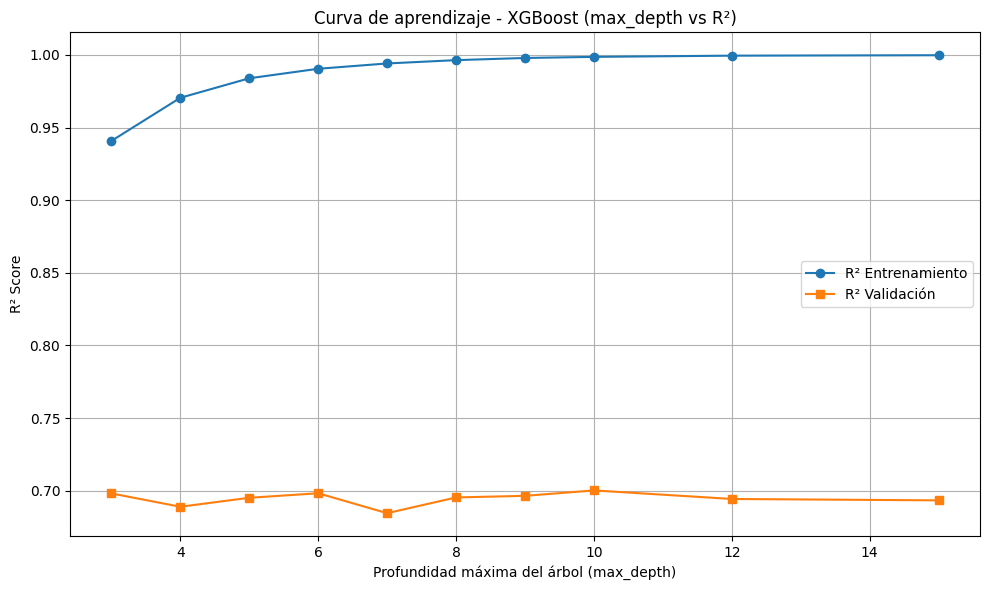

In [262]:
# Lista de profundidades a probar
max_depths = [3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
train_scores = []
valid_scores = []

for depth in max_depths:
    xgb = XGBRegressor(
        n_estimators=100,
        max_depth=depth,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train_tree, y_train)

    train_r2 = xgb.score(X_train_tree, y_train)
    valid_r2 = xgb.score(X_valid_tree, y_valid)

    train_scores.append(train_r2)
    valid_scores.append(valid_r2)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, label='R² Entrenamiento', marker='o')
plt.plot(max_depths, valid_scores, label='R² Validación', marker='s')
plt.xlabel('Profundidad máxima del árbol (max_depth)')
plt.ylabel('R² Score')
plt.title('Curva de aprendizaje - XGBoost (max_depth vs R²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### 5.4.2. Curva de aprendizaje número de estimadores (árboles)

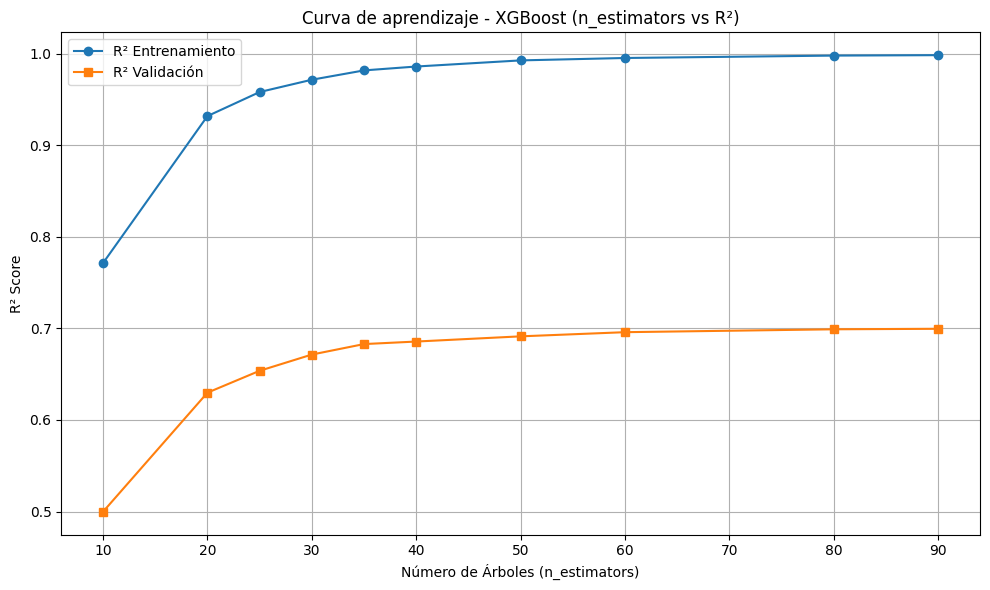

In [166]:
# Lista de n_estimators a probar
n_estimators_list = [10, 20, 25, 30, 35, 40, 50, 60, 80, 90]
train_scores = []
valid_scores = []

for n in n_estimators_list:
    xgb = XGBRegressor(
        n_estimators=n,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_train_tree, y_train)

    train_r2 = xgb.score(X_train_tree, y_train)
    valid_r2 = xgb.score(X_valid_tree, y_valid)

    train_scores.append(train_r2)
    valid_scores.append(valid_r2)

# Visualización
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, train_scores, label='R² Entrenamiento', marker='o')
plt.plot(n_estimators_list, valid_scores, label='R² Validación', marker='s')
plt.xlabel('Número de Árboles (n_estimators)')
plt.ylabel('R² Score')
plt.title('Curva de aprendizaje - XGBoost (n_estimators vs R²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### 5.4.3. Entrenamiento

In [377]:
# Creamos el modelo de xgboost
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definimos los hiperparámetros a buscar
param_grid = {
    'max_depth': [5, 6],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

# Creamos la validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Configuramos GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=kfold,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(
    X_train_tree, y_train,
    **{
        'eval_set': [(X_valid_tree, y_valid)],
        #'early_stopping_rounds': 10,
        'verbose': False
    }
)

# Mejor modelo encontrado
best_xgb = grid_search.best_estimator_
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7}


##### 5.4.4. Predicción

In [429]:
y_train_pred_xgb = best_xgb.predict(X_train_tree)
y_valid_pred_xgb = best_xgb.predict(X_valid_tree)
y_test_pred_xgb = best_xgb.predict(X_test_tree)

##### 5.4.5. Métricas

In [432]:
r2_train_xgb, mae_train_xgb, rmse_train_xgb = calcular_metricas(y_train, y_train_pred_xgb)
r2_valid_xgb, mae_valid_xgb, rmse_valid_xgb = calcular_metricas(y_valid, y_valid_pred_xgb)
r2_test_xgb, mae_test_xgb, rmse_test_xgb = calcular_metricas(y_test, y_test_pred_xgb)

print("XGBoost:")
print(f"Entrenamiento → R²: {r2_train_xgb:.3f}, MAE: {mae_train_xgb:.2f}, RMSE: {rmse_train_xgb:.2f}")
print(f"Validación    → R²: {r2_valid_xgb:.3f}, MAE: {mae_valid_xgb:.2f}, RMSE: {rmse_valid_xgb:.2f}")
print(f"Test          → R²: {r2_test_xgb:.3f}, MAE: {mae_test_xgb:.2f}, RMSE: {rmse_test_xgb:.2f}")

XGBoost:
Entrenamiento → R²: 0.974, MAE: 551.15, RMSE: 1346.89
Validación    → R²: 0.705, MAE: 1112.59, RMSE: 6657.26
Test          → R²: 0.890, MAE: 756.03, RMSE: 2726.50


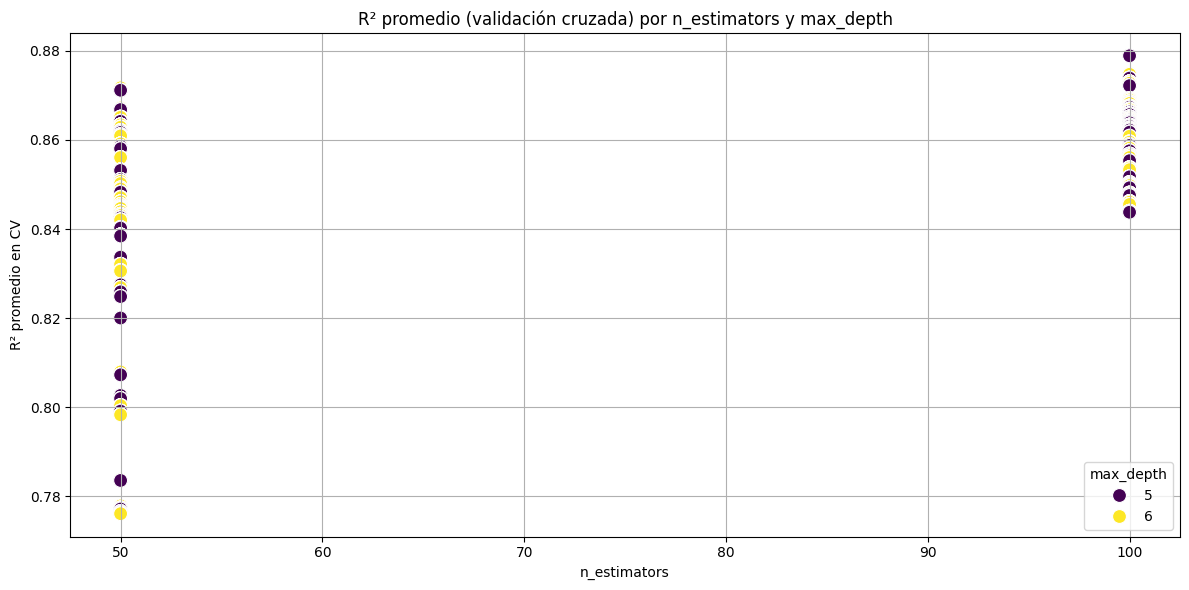

In [433]:
# Convertir resultados a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Ordenar por por R² promedio
results_df = results_df.sort_values(by='mean_test_score', ascending=False)

# Graficar: comparación de R² según n_estimators y max_depth
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_depth',
    palette='viridis',
    s=100
)
plt.title('R² promedio (validación cruzada) por n_estimators y max_depth')
plt.xlabel('n_estimators')
plt.ylabel('R² promedio en CV')
plt.legend(title='max_depth')
plt.grid(True)
plt.tight_layout()
plt.show()

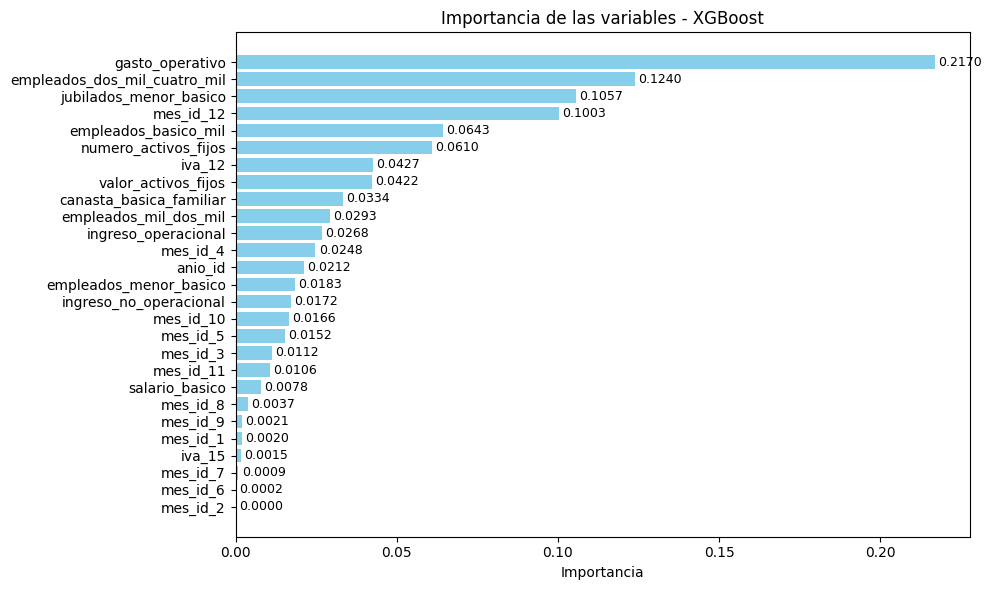

In [435]:
# Obtener importancias y nombres de features
importances = best_xgb.feature_importances_
features = X_train_tree.columns
indices = np.argsort(importances)  # ordenar de menor a mayor

# Ordenar variables e importancias para graficar de forma ordenada
features_sorted = np.array(features)[indices]
importances_sorted = importances[indices]

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(features_sorted, importances_sorted, color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de las variables - XGBoost')

# Añadir valores al final de cada barra
for bar, value in zip(bars, importances_sorted):
    plt.text(value + 0.001, bar.get_y() + bar.get_height()/2,
             f'{value:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

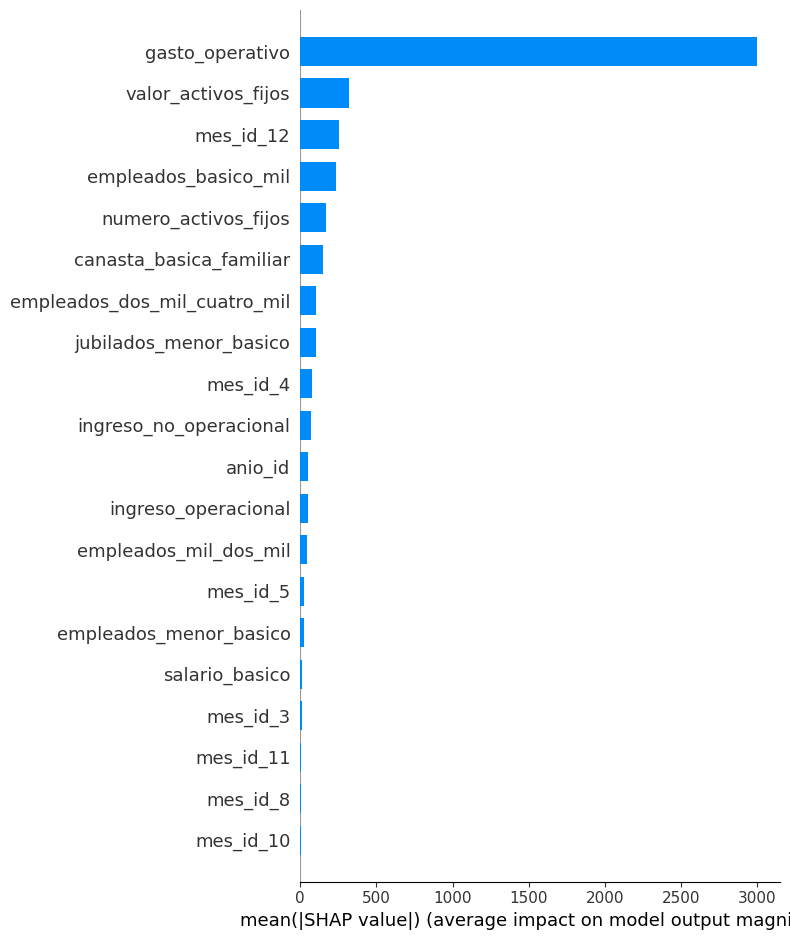

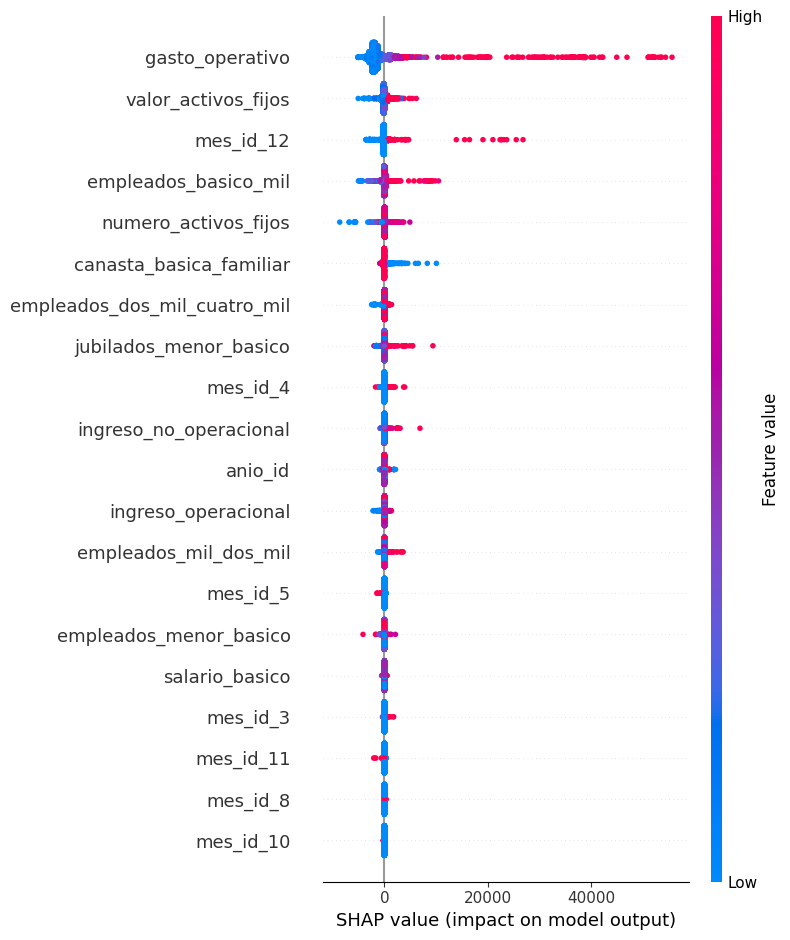

In [436]:
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_tree)

# Gráfico de resumen (tipo barra)
shap.summary_plot(shap_values, X_train_tree, plot_type="bar")

# Gráfico de resumen (tipo dot para más detalle)
shap.summary_plot(shap_values, X_train_tree)

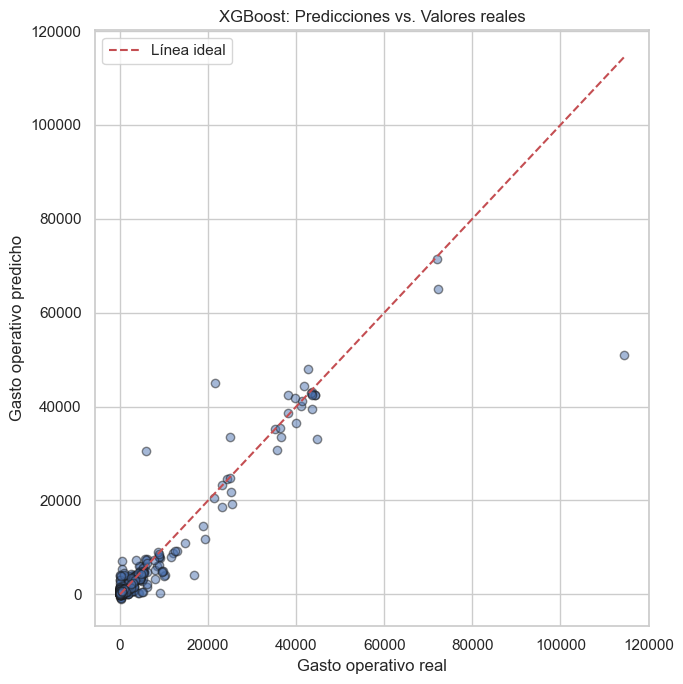

In [532]:
# Gráfico de dispersión
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', label='Línea ideal')

plt.xlabel('Gasto operativo real')
plt.ylabel('Gasto operativo predicho')
plt.title('XGBoost: Predicciones vs. Valores reales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### 5.4. Red neuronal artificial

##### 5.4.1. Creación de early stop

In [441]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

##### 5.4.2. Creación del modelo

In [443]:
model_rna = keras.Sequential([
    layers.Input(shape=(27,)),

    layers.BatchNormalization(),
    layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.BatchNormalization(),
    layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    layers.BatchNormalization(),
    layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),

    layers.Dense(1, activation='relu')  # salida positiva
])

model_rna.compile(
    optimizer=AdamW(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model_rna.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_18          │ (None, 27)             │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,685 (33.93 KB)

 Trainable params: 8,375 (32.71 KB)

 Non-trainable params: 310 (1.21 KB)

##### 5.4.3. Entrenamiento del modelo

In [445]:
history = model.fit(
    X_train_rna, y_train_rna,
    validation_data=(X_valid_rna, y_valid_rna),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 8.


##### 5.4.4. Predicciones

In [447]:
y_train_pred_rna = target_rna.inverse_transform(model.predict(X_train_rna).flatten().reshape(-1, 1))
y_valid_pred_rna = target_rna.inverse_transform(model.predict(X_valid_rna).flatten().reshape(-1, 1))
y_test_pred_rna  = target_rna.inverse_transform(model.predict(X_test_rna).flatten().reshape(-1, 1))

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


##### 5.4.5. Métricas

In [450]:
y_train_real = target_rna.inverse_transform(y_train_rna.reshape(-1, 1))
y_valid_real = target_rna.inverse_transform(y_valid_rna.reshape(-1, 1))
y_test_real = target_rna.inverse_transform(y_test_rna.reshape(-1, 1))

r2_train_rna, mae_train_rna, rmse_train_rna = calcular_metricas(y_train_real, y_train_pred_rna)
r2_valid_rna, mae_valid_rna, rmse_valid_rna = calcular_metricas(y_valid_real, y_valid_pred_rna)
r2_test_rna, mae_test_rna, rmse_test_rna = calcular_metricas(y_test_real, y_test_pred_rna)

print("Red neuronal:")
print(f"Entrenamiento → R²: {r2_train_rna:.3f}, MAE: {mae_train_rna:.2f}, RMSE: {rmse_train_rna:.2f}")
print(f"Validación    → R²: {r2_valid_rna:.3f}, MAE: {mae_valid_rna:.2f}, RMSE: {rmse_valid_rna:.2f}")
print(f"Test          → R²: {r2_test_rna:.3f}, MAE: {mae_test_rna:.2f}, RMSE: {rmse_test_rna:.2f}")

Red neuronal:
Entrenamiento → R²: 0.874, MAE: 1152.67, RMSE: 2955.03
Validación    → R²: 0.693, MAE: 1567.27, RMSE: 6786.06
Test          → R²: 0.817, MAE: 1274.60, RMSE: 3518.15


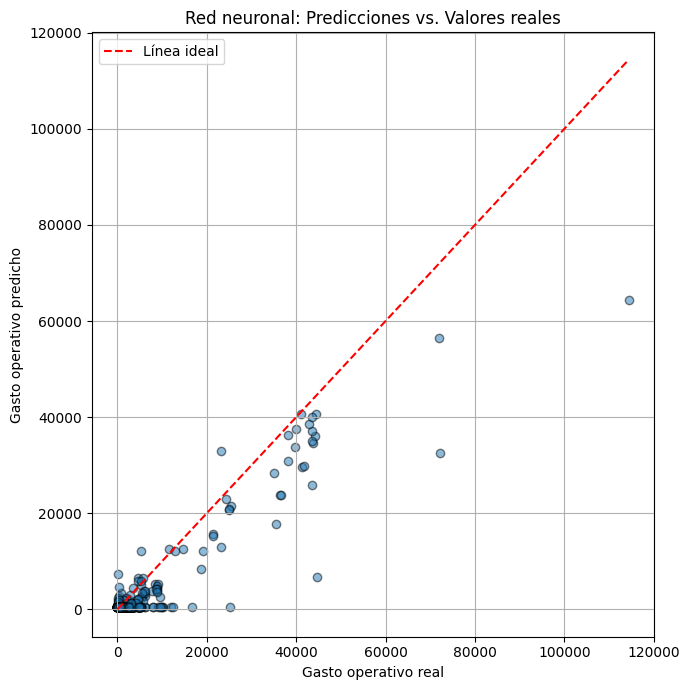

In [451]:
# Gráfico de dispersión
plt.figure(figsize=(7, 7))
plt.scatter(y_test_real, y_test_pred_rna, alpha=0.5, edgecolor='k')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--', label='Línea ideal')

plt.xlabel('Gasto operativo real')
plt.ylabel('Gasto operativo predicho')
plt.title('Red neuronal: Predicciones vs. Valores reales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 6. Armado y exportacion de resultados

In [453]:
# Crear lista de filas
filas = []

# Regresión lineal
filas.append(['Regresión Lineal', 'Entrenamiento', r2_train_lr, mae_train_lr, rmse_train_lr])
filas.append(['Regresión Lineal', 'Validación', r2_valid_lr, mae_valid_lr, rmse_valid_lr])
filas.append(['Regresión Lineal', 'Test', r2_test_lr, mae_test_lr, rmse_test_lr])

# Árboles de decisión
filas.append(['Árboles de Decisión', 'Entrenamiento', r2_train_dt, mae_train_dt, rmse_train_dt])
filas.append(['Árboles de Decisión', 'Validación', r2_valid_dt, mae_valid_dt, rmse_valid_dt])
filas.append(['Árboles de Decisión', 'Test', r2_test_dt, mae_test_dt, rmse_test_dt])

# Random Forest
filas.append(['Random Forest', 'Entrenamiento', r2_train_rf, mae_train_rf, rmse_train_rf])
filas.append(['Random Forest', 'Validación', r2_valid_rf, mae_valid_rf, rmse_valid_rf])
filas.append(['Random Forest', 'Test', r2_test_rf, mae_test_rf, rmse_test_rf])

# XGBoost
filas.append(['XGBoost', 'Entrenamiento', r2_train_xgb, mae_train_xgb, rmse_train_xgb])
filas.append(['XGBoost', 'Validación', r2_valid_xgb, mae_valid_xgb, rmse_valid_xgb])
filas.append(['XGBoost', 'Test', r2_test_xgb, mae_test_xgb, rmse_test_xgb])

# Red Neuronal
filas.append(['Red Neuronal', 'Entrenamiento', r2_train_rna, mae_train_rna, rmse_train_rna])
filas.append(['Red Neuronal', 'Validación', r2_valid_rna, mae_valid_rna, rmse_valid_rna])
filas.append(['Red Neuronal', 'Test', r2_test_rna, mae_test_rna, rmse_test_rna])

# Crear DataFrame
df_metricas_wide = pd.DataFrame(filas, columns=['Modelo', 'Conjunto', 'R2 valor', 'MAE valor', 'RMSE valor'])

# Mostrar la tabla
print("Tabla en formato ancho con métricas separadas:")
display(df_metricas_wide)

df_metricas_wide.to_csv("metricas_modelos.csv", index=False)

Tabla en formato ancho con métricas separadas:


Modelo       Conjunto  R2 valor    MAE valor   RMSE valor
0      Regresión Lineal  Entrenamiento  0.623339  1880.716194  5113.859943
1      Regresión Lineal     Validación  0.511251  2216.455905  8567.967948
2      Regresión Lineal           Test  0.722230  1773.985945  4333.940096
3   Árboles de Decisión  Entrenamiento  0.933481   511.637909  2149.045179
4   Árboles de Decisión     Validación  0.686012  1040.557771  6867.383105
5   Árboles de Decisión           Test  0.861577   745.650687  3059.459756
6         Random Forest  Entrenamiento  0.956767   434.630279  1732.522399
7         Random Forest     Validación  0.716381   960.802828  6526.830545
8         Random Forest           Test  0.884376   677.868059  2796.172333
9               XGBoost  Entrenamiento  0.973871   551.145990  1346.892430
10              XGBoost     Validación  0.704932  1112.587131  6657.263806
11              XGBoost           Test  0.890066   756.026859  2726.498981
12         Red Neuronal  Entrenamiento  0.874230  1152.668174  2955.031080
13         Red Neuronal     Validación  0.693404  1567.266074  6786.060303
14         Red Neuronal           Test  0.816959  1274.604842  3518.148495

### 7. Conclusiones y elección de modelo

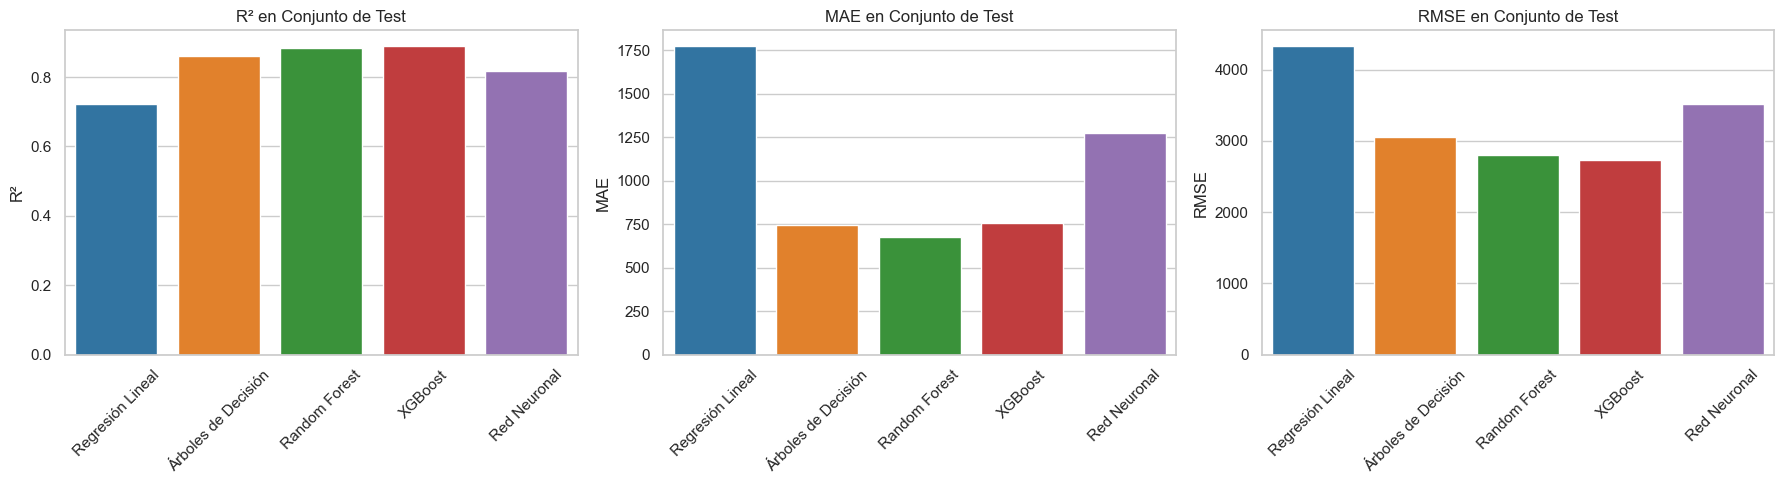

In [467]:
# Filtrar solo las filas del conjunto Test
df_test = df_metricas_wide[df_metricas_wide['Conjunto'] == 'Test']

# Establecer estilo
sns.set(style="whitegrid")
colores = sns.color_palette("tab10", len(df_test))

# Crear figuras
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico R²
sns.barplot(x='Modelo', y='R2 valor', hue='Modelo', data=df_test, ax=axes[0], palette=colores, legend=False)
axes[0].set_title('R² en Conjunto de Test')
axes[0].set_ylabel('R²')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico MAE
sns.barplot(x='Modelo', y='MAE valor', hue='Modelo', data=df_test, ax=axes[1], palette=colores, legend=False)
axes[1].set_title('MAE en Conjunto de Test')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

# Gráfico RMSE
sns.barplot(x='Modelo', y='RMSE valor', hue='Modelo', data=df_test, ax=axes[2], palette=colores, legend=False)
axes[2].set_title('RMSE en Conjunto de Test')
axes[2].set_ylabel('RMSE')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45)

# Ajustar diseño
plt.tight_layout()
plt.show()


### 8. Exportar modelo ganador para rpedicciones en tiempo real

#### 8.1. Creamos ColumnTransformer para encolar el procesamiento de los datos

In [547]:
# Columnas por tipo de transformación
# anio_id no va por que es la única que no sufre transformaciones
standard_cols = [
    'salario_basico', 'canasta_basica_familiar',
    'numero_activos_fijos', 'empleados_menor_basico', 'empleados_basico_mil',
    'empleados_mil_dos_mil', 'empleados_dos_mil_cuatro_mil',
    'jubilados_menor_basico'
]

robust_cols = ['valor_activos_fijos', 'ingreso_operacional', 'ingreso_no_operacional']

onehot_cols = ['mes_id', 'iva']
target_col = 'gasto_operativo'

# Columnas que quedan (las numéricas sin transformación explícita)
drop_cols = onehot_cols + [target_col]

# Subconjunto base de entrada para el modelo
base_cols = [col for col in X_train.columns if col not in drop_cols]

# Pipeline de transformaciones
preprocessor = ColumnTransformer(transformers=[
    ('std', StandardScaler(), standard_cols),
    ('rob', RobustScaler(), robust_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), onehot_cols),
    ('te', TargetEncoder(), [target_col])
], remainder='passthrough')  # Para que la columna anio_id sea conservada

#### 8.2. Pipeline y exportar modelo de random forest

In [553]:
# Crear pipeline final con modelo
random_forest_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(
        max_depth=13,
        n_estimators=10,
        min_samples_split=2,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenar el pipeline con X_train completo
X_train_all = X_train.copy()
y_train_all = y_train.copy()

random_forest_pipeline.fit(X_train_all, y_train_all)

# Exportar con joblib
joblib.dump(random_forest_pipeline, 'modelo_random_forest_pipeline.joblib')
print("Modelo exportado como 'modelo_random_forest_pipeline.joblib'")

Modelo exportado como 'modelo_random_forest_pipeline.joblib'


#### 8.3. Pipeline y exportar modelo de XGBoost

In [556]:
# Usamos el mejor modelo encontrado en GridSearchCV
best_xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.8,
    gamma=0,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=3,
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1,
    subsample=0.7
)

# Pipeline con XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', best_xgb)
])

# Entrenamiento del pipeline
X_train_all = X_train.copy()
y_train_all = y_train.copy()

xgb_pipeline.fit(X_train_all, y_train_all)

# Exportar a archivo .joblib
joblib.dump(xgb_pipeline, 'modelo_xgboost_pipeline.joblib')
print("Modelo exportado como 'modelo_xgboost_pipeline.joblib'")

Modelo exportado como 'modelo_xgboost_pipeline.joblib'


In [560]:
# Cargar modelo
modelo_cargado_random_forest = joblib.load('modelo_random_forest_pipeline.joblib')
modelo_cargado_xbg = joblib.load('modelo_xgboost_pipeline.joblib')
# Predecir
y_train_pred_rf = modelo_cargado_random_forest.predict(X_test)
y_train_pred_xbg = modelo_cargado_xbg.predict(X_test)

In [564]:
r2 = r2_score(y_test, y_train_pred_rf)
mae = mean_absolute_error(y_test, y_train_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_train_pred_rf))

print("Random forest:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Random forest:
R²: 0.8864
MAE: 670.25
RMSE: 2771.18


In [566]:
r2 = r2_score(y_test, y_train_pred_xbg)
mae = mean_absolute_error(y_test, y_train_pred_xbg)
rmse = np.sqrt(mean_squared_error(y_test, y_train_pred_xbg))

print("XGBoost:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

XGBoost:
R²: 0.8910
MAE: 769.05
RMSE: 2714.90
